In [99]:
## to widen the cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [100]:
### If autocomplete is toooo slow: https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working 
%config Completer.use_jedi = False 

In [ ]:
%%bash
## to make cursor hidden on iTerms2:
tput civis

## to make cursor visibl on iTerms2:
tput cvvis


## 1. Spatial gene expression data preparation 

In [ ]:
import SpXP
df_norm_nodup_nonan = SpXP.func_df_spatial_xp(p = .8, int_bool=False)
df_final = df_norm_nodup_nonan
df_final

In [ ]:
df_final.T

In [ ]:
df_final.T.to_csv('df_norm_nodup_nonan_p.8_.T.txt',sep = '\t')

In [ ]:
df_final_partial = df_final.T.iloc[:1000, :500]
df_final_partial.to_csv('df_norm_parial.txt', sep = '\t')
df_final_partial

In [ ]:
dd = pd.read_csv('df_norm_parial.txt', sep= '\t', index_col=0)
dd

In [ ]:
import SpXP
df_int_nodup_nonan = SpXP.func_df_spatial_xp(p = .8, int_bool=True) ### this takes very long time. The data have already been produced via SpXP_StandAlone.py
df_final = df_int_nodup_nonan
df_final

## 2. Go-terms prepration:
http://www.informatics.jax.org/downloads/reports/gene_association.mgi.gz

`@avicenna:` /nvme/bins/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/mouse_gs/gene_association.mgi

http://www.informatics.jax.org/downloads/reports/index.html#go
http://www.informatics.jax.org/faq/GO_dload.shtml


In [ ]:
gene_mgi = pd.read_csv('gene_association.mgi', sep = '\t', comment='!', header=None)
goterm = pd.read_csv('go_terms.mgi', sep = '\t', header = None)

gene_mgi.columns = ["DatabaseDesignation","MGI_Marker_Accession_ID","Mouse_Marker_Symbol","NOT_Designation"
                  ,"GO_Term_ID","MGI_Reference_Accession_ID","GOـEvidence_Code","Inferred_From",
                  "Ontology","Mouse_Marker_Name","Mouse_Marker_Synonyms","Mouse_Marker_Type",
                  "Taxon","Modification_Date","Assigned_By","Annotation_Extension","Gene_Product"]
dd = gene_mgi['Mouse_Marker_Symbol'].isin(df_norm_nodup_nonan.index[3:])
gene_mgi = gene_mgi.loc[dd,:] ## subset gene_mgi[] to those genes for which we have XP data in df_norm_nodup_nonan[]
gene_mgi.reset_index(inplace=True, drop = True)

gene_mgi.insert(loc = 5, column = 'GO_Term', value = '')



goterm.columns = ['Ontology','GO_ID', 'GO_Term']
goterm['GO_Term'] = goterm['GO_Term'].str.upper()

# gene_mgi[gene_mgi.index.isin(g.index)]
gene_mgi



In [1]:
goterm#.head()

NameError: name 'goterm' is not defined

In [ ]:
t = gene_mgi
g = goterm

t = t.set_index('GO_Term_ID', drop = True )
g = g.set_index('GO_ID', drop = True)

t = t[t.index.isin(g.index)] ## subset rows for which there is a go-term

a = np.array([ g.GO_Term[g.index == t.index[i]] for i in range(len(t)) ]) # go-terms per each gene in t[]
t.loc[:,'GO_Term']  = np.array(a) ## adding go-terms to t[]

gene_mgi = t
goterm = g


In [ ]:
goterm#.head()

In [ ]:
### function  cartesian_product_transpose

import functools
def cartesian_product_transpose(*arrays):
    """
    http://stackoverflow.com/a/11146645/190597 (senderle)
    """
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    dtype = np.find_common_type([arr.dtype for arr in broadcasted], [])
    rows, cols = functools.reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T
### end of function 


In [ ]:
import copy
tt = copy.deepcopy(gene_mgi.loc[:,['Mouse_Marker_Symbol', 'GO_Term']])
tt = tt.reset_index(drop = True)
tt
# tt = tt.set_index('GO_Term', drop = True)
uniqgoterms = tt.GO_Term.unique()
uniqgenes = tt.Mouse_Marker_Symbol.unique()

gene_vs_goterm = pd.DataFrame(index=uniqgenes, columns=uniqgoterms)

for g in gene_vs_goterm.index:
    gene_vs_goterm.loc[g].loc[tt.GO_Term[tt.Mouse_Marker_Symbol==g]] = 1 ## assign 1's to genes w/ related go-terms
gene_vs_goterm[gene_vs_goterm.isnull()] = 0
gene_vs_goterm

In [ ]:
gene_vs_goterm.to_csv('gene_vs_goterm.txt', sep ='\t')



In [ ]:
gg = pd.read_csv('gene_vs_goterm.txt' , sep = '\t', index_col=0)

In [ ]:
gg

In [ ]:
## double check 
gg.columns.equals(gene_vs_goterm.columns)
gg.index.equals(gene_vs_goterm.index)
aa = gg==gene_vs_goterm
aa.all().shape[0] == gg.shape[1] ## --> all values along all columns in gg[] & gene_vs_gotermp[] are the same 

In [ ]:
aa

<a id='Doing_the_analysis'></a>

## 3.  Doing the analysis:



If you want the z-normalized data,  run **`1. Spatial gene expression data preparation`** above then come back here! ( skip `2. Go-terms prepration:`). 


If rank-based inverse normal transformed, just read them as following (ie skip **`1`** and **`2`** above):


#### 3.1 Read Rank-Based Inverse Normal Transformed (instead of just normalized) version of expression data [***you can skip this one and jump to [`3.3  READ DATA`](#read_df) to directly read the `df_final_imputed.txt` & `xyz_coor_final.txt`***]



It takes a very long time to calcualted rank-based INT of the original spatial expression (the following code). So since rank-based INT data have already been produced via `SpXP_StandAlone.py` and saved into `df_int_nodup_nonan.txt`, we just skip the following and read the Rank-based Inverse Normal Transformed from `df_int_nodup_nonan.txt` in the after-next cell

In [9]:
import pandas as pd
import numpy as np
df_final_orig = pd.read_csv('df_int_nodup_nonan.txt', sep = '\t', index_col=0)
# df_final_orig = pd.read_csv('head_df_int_nodup_nonan.txt', sep='\t', index_col=0) ## to test readibility
# print(df_final_orig.shape)
df_final_orig

,cube_22175,cube_22176,cube_22177,cube_22178,cube_22179,cube_22180,cube_22181,cube_22182,cube_22183,cube_22184,...,cube_156399,cube_156400,cube_156401,cube_156402,cube_156403,cube_156404,cube_156405,cube_156406,cube_156407,cube_156408
x,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
y,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
z,19.000000,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,...,31.000000,32.000000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000
Inpp5a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.210803,0.000765,0.104145,0.376903,0.474577,0.563406,0.555486,0.288968,-0.061704,-0.115828
Snap47,1.766016,2.040814,1.983605,1.941953,2.000904,1.947792,1.851297,1.847497,1.826946,1.736981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gsn,0.686499,0.423012,0.219791,0.148225,0.047295,-0.108776,-0.240071,-0.298582,-0.360393,-0.032364,...,1.698000,1.539610,1.459904,1.427236,1.501223,1.540383,1.392295,1.141360,0.925169,0.765496
Sptssa,-0.368594,-0.590113,-0.797623,-0.866045,-0.914299,-0.920729,-0.901958,-1.045533,-1.342864,-0.911875,...,-0.674910,-0.603824,-0.346181,-0.276849,-0.374202,-0.583208,-0.619997,-0.523742,-0.520055,-0.681677
Nkain4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.677795,0.739995,0.761741,0.752348,0.767086,0.846884,1.070060,1.433293,1.795943,2.003628
Eno2,2.721736,2.570824,2.447237,2.432480,2.513911,2.551908,2.572615,2.572930,2.480577,1.933042,...,2.664644,2.692382,2.790643,2.570929,2.403623,2.639525,2.754943,2.925973,2.925593,2.350189


In [16]:
## create df input and outputs
df_final = df_final_orig.copy()

dftemp = df_final.iloc[3:,:]

dd = dftemp.index.isin(gene_vs_goterm.index)
dftemp = dftemp.loc[dd,:] ## subset of df_final[] for which there are go-term in gene_vs_goterm[]
dftemp = dftemp.sort_index()

dftemp = pd.concat([df_final.iloc[:3,:], dftemp]) ## add back x,y,z per cube

df_final = dftemp #re-construct df_final[] by copying back to df_final[]
df_final = df_final.T
xyz_coor = df_final.iloc[:,:3] ## extract xyz cols from df_final[]
df_final = df_final.iloc[:,3:] ## remove xyz cols from df_final[]

df_final.to_csv('df_final.txt', sep ='\t')

xyz_coor.to_csv('xyz_coor_final.txt', sep = '\t')

xyz_coor

,x,y,z
cube_22175,9.0,13.0,19.0
cube_22176,9.0,13.0,20.0
cube_22177,9.0,13.0,21.0
cube_22178,9.0,13.0,22.0
cube_22179,9.0,13.0,23.0
...,...,...,...
cube_156404,65.0,31.0,36.0
cube_156405,65.0,31.0,37.0
cube_156406,65.0,31.0,38.0
cube_156407,65.0,31.0,39.0


#### Impute `df_final` NaN

In [17]:
xyz_coor.to_csv('xyz_coor_final2.txt', sep = '\t')

In [ ]:
## impute/imputation
from sklearn.impute import SimpleImputer


## detect and remove columns w/ ALL NaN in trial version
allnan_cols = df_final.columns[df_final.isna().all()]
print(type(allnan_cols) , allnan_cols)
df_final = df_final.drop(columns = allnan_cols)

### impute NaN (for columns which are not all.nan)
ruh_imputer_instace = SimpleImputer(missing_values=np.NaN,strategy = 'median') #, add_indicator=True)


df_imputed = pd.DataFrame(ruh_imputer_instace.fit_transform(df_final))
df_imputed.columns = df_final.columns
df_imputed.index = df_final.index

df_final = df_imputed

df_final.to_csv('df_final_imputed.txt', sep ='\t')


df_final





In [ ]:
## impute using KNN

df_final = df_final_orig.copy() ##w/ NaN
from sklearn.impute import KNNImputer

## detect and remove columns w/ ALL NaN 
allnan_cols = df_final.columns[df_final.isna().all()]
print(type(allnan_cols) , allnan_cols)
df_final = df_final.drop(columns = allnan_cols)

# ### impute NaN (for columns which are not all.nan)
ruh_imputer_instace = KNNImputer(missing_values=np.NaN,n_neighbors=10) #, add_indicator=True)


df_imputed = pd.DataFrame(ruh_imputer_instace.fit_transform(df_final))
df_imputed.columns = df_final.columns
df_imputed.index = df_final.index

df_final = df_imputed



<class 'pandas.core.indexes.base.Index'> Index([], dtype='object')


<a id='read_df'></a>


### 3.3 READ DATA



#### 3.3.0 read the df_final: original & imputed, either both or only one

In [1]:
import pandas as pd
import numpy as np

# df_final = pd.read_csv('df_final.txt' , sep = '\t', index_col=0) #has NaNs
# df_final_orig = df_final.copy()


# df_final_imputed = pd.read_csv('df_final_imputed.txt' , sep = '\t', index_col=0) ## simple median imputed
df_final_imputed = pd.read_csv('df_final_imputed_KNN10.txt' , sep = '\t', index_col=0) ##KNN imputed

df_final_imputed_orig = df_final_imputed.copy() #make an extra copy


#### 3.2 Read gene vs goterms
gene_vs_goterm = pd.read_csv('gene_vs_goterm.txt' , sep = '\t', index_col=0)
gene_vs_goterm = gene_vs_goterm.sort_index(axis=0)
gene_vs_goterm 

,MOLECULAR_FUNCTION,CELLULAR_COMPONENT,BIOLOGICAL_PROCESS,CENTROSOME,CYTOSOL,CENTRIOLAR_SATELLITE,PROTEIN_LOCALIZATION_TO_CENTROSOME,MEMBRANE,INTEGRAL_COMPONENT_OF_MEMBRANE,GLOBOSIDE_BIOSYNTHETIC_PROCESS,...,CLOACAL_SEPTATION,GLOMERULAR_VISCERAL_EPITHELIAL_CELL_DEVELOPMENT,GLOMERULUS_VASCULATURE_DEVELOPMENT,METANEPHRIC_NEPHRON_TUBULE_MORPHOGENESIS,OPTIC_PLACODE_FORMATION_INVOLVED_IN_CAMERA-TYPE_EYE_FORMATION,METANEPHRIC_S-SHAPED_BODY_MORPHOGENESIS,SCLEROTOME_DEVELOPMENT,URETER_UROTHELIUM_DEVELOPMENT,LIMBIC_SYSTEM_DEVELOPMENT,ENDOPLASMIC_RETICULUM_QUALITY_CONTROL_COMPARTMENT
0610010F05Rik,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1110008P14Rik,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1700037H04Rik,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1700086L19Rik,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2900026A02Rik,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zmynd11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Znrf1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Zscan22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zswim6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
if df_final_imputed.isna().sum().sum() != 0:
    print('THERE ARE NaNs in df_final_imputed[] ') #if != 0 => row/col MUST BE deleted 
    input("Press Enter to continue...")

In [3]:
import copy

xyz_coor = pd.read_csv('xyz_coor_final.txt' , sep = '\t', index_col=0)

xyz_coor_abs = xyz_coor.copy()


## deep vs shallow copy methods:

# xyz_coor.copy() YES INDEPENDENY COPY
# copy.deepcopy(xyz_coor) YES INDEPENDENY COPY

# xyz_coor[:] NO INDEPENDENT COPY--> this approach works for list though
# pd.DataFrame(xyz_coor) NO INDEPENDENT COPY

xyz_coor_abs

,x,y,z
cube_22175,9.0,13.0,19.0
cube_22176,9.0,13.0,20.0
cube_22177,9.0,13.0,21.0
cube_22178,9.0,13.0,22.0
cube_22179,9.0,13.0,23.0
...,...,...,...
cube_156404,65.0,31.0,36.0
cube_156405,65.0,31.0,37.0
cube_156406,65.0,31.0,38.0
cube_156407,65.0,31.0,39.0


In [4]:
## scale coor to [0,1]

xyz_coor.x = (xyz_coor.x-min(xyz_coor.x))/(max(xyz_coor.x)-min(xyz_coor.x)) 
xyz_coor.y = (xyz_coor.y-min(xyz_coor.y))/(max(xyz_coor.y)-min(xyz_coor.y))
xyz_coor.z = (xyz_coor.z-min(xyz_coor.z))/(max(xyz_coor.z)-min(xyz_coor.z))

xyz_coor


,x,y,z
cube_22175,0.0,0.333333,0.327273
cube_22176,0.0,0.333333,0.345455
cube_22177,0.0,0.333333,0.363636
cube_22178,0.0,0.333333,0.381818
cube_22179,0.0,0.333333,0.400000
...,...,...,...
cube_156404,1.0,0.833333,0.636364
cube_156405,1.0,0.833333,0.654545
cube_156406,1.0,0.833333,0.672727
cube_156407,1.0,0.833333,0.690909


In [5]:
## find spherical coor:
from ai import cs
# rsph,thetasph,phi = cs.cart2sp(x = xyz_coor_abs.x, y = xyz_coor_abs.y , z = xyz_coor_abs.z)
# rcyl,thetacyl, h = cs.cart2cyl(x = xyz_coor_abs.x, y = xyz_coor_abs.y , z = xyz_coor_abs.z)


rsph,thetasph,phi = cs.cart2sp(x = xyz_coor.x, y = xyz_coor.y , z = xyz_coor.z)
rcyl,thetacyl, h = cs.cart2cyl(x = xyz_coor.x, y = xyz_coor.y , z = xyz_coor.z)


xyz_coor['rsph'], xyz_coor['thetasph'], xyz_coor['phi'],xyz_coor['rcyl'], xyz_coor['thetacyl'], xyz_coor['h'] = [rsph,thetasph,phi, rcyl, thetacyl, h]
xyz_coor



,x,y,z,rsph,thetasph,phi,rcyl,thetacyl,h
cube_22175,0.0,0.333333,0.327273,0.467139,0.776224,1.570796,0.333333,1.570796,0.327273
cube_22176,0.0,0.333333,0.345455,0.480052,0.803253,1.570796,0.333333,1.570796,0.345455
cube_22177,0.0,0.333333,0.363636,0.493298,0.828849,1.570796,0.333333,1.570796,0.363636
cube_22178,0.0,0.333333,0.381818,0.506849,0.853091,1.570796,0.333333,1.570796,0.381818
cube_22179,0.0,0.333333,0.400000,0.520683,0.876058,1.570796,0.333333,1.570796,0.400000
...,...,...,...,...,...,...,...,...,...
cube_156404,1.0,0.833333,0.636364,1.448932,0.454702,0.694738,1.301708,0.694738,0.636364
cube_156405,1.0,0.833333,0.654545,1.457009,0.465914,0.694738,1.301708,0.694738,0.654545
cube_156406,1.0,0.833333,0.672727,1.465267,0.477000,0.694738,1.301708,0.694738,0.672727
cube_156407,1.0,0.833333,0.690909,1.473703,0.487960,0.694738,1.301708,0.694738,0.690909



<a id='create_trial_version'></a>

### create trial version (=subset) of the SPATIAL XP for the ease of use



[LINK UP TO **3.3 READ DATA**](#read_df)


[Link down to ***MLP based on Functional API for SPATIAL XP data***](#MLP_Functional_API_for_SPATIAL_XP_data)

[Linke down to the beginning of ***Stacked AE***](#stacked_ae)

[Link down to the beginning of ***Reg stacked AE w/ shared layer***](#reg_stacked_ae)

[Link down to the beginning of ***VAE***](#vae)

[Link down to the beginning of ***Csutom VAE***](#custom_vae)

[Link down to beginning of the ***talos hyperparam tuning for custom VAE***](#talos_custom_vae)

[Link down to: ***KerasRegressor for FUNCTIONAL API / SPATIAL XP*** ](#KerasRegressor_for_FUNCTIONAL_API)

In [131]:
import random
import tensorflow.keras as kr
import sklearn as sk
import tensorflow as tf
from sklearn.model_selection import KFold

df_final = df_final_imputed_orig.copy() ## no NaNs

# df_final = df_final_orig.copy() ## including NaNs


## create the trial version ( = a subset of df_final to play w/ different nn architectures)
ncube = 1000 #df_final.shape[0] #8500  #20000 # #2000
ngenes = 500# df_final.shape[1] #500# #500
ngoterm =  100 #gene_vs_goterm.shape[1] #300
random.seed(123)

i = random.sample(range(len(df_final)) , ncube )
j = random.sample(range(df_final.shape[1]), ngenes)
i.sort()
j.sort()



df_trial = df_final.iloc[i,j] #df_final.iloc[:ncube,3:(ngenes+3)]
cart = 3 ; cart_sph = 6 ; cart_sph_cyl = 9
xyz_coor_trial = xyz_coor.iloc[i, 0:cart_sph_cyl]

gvgo_trial = gene_vs_goterm.iloc[j, :ngoterm]



print('df_trial shape:',df_trial.shape)
print('xyz_coor_trial shape:',xyz_coor_trial.shape)
print('gvgo_trial shape: ', gvgo_trial.shape)


## split SPATIAL XP trial data into test & train & validation
## create test & train as a subset of trial version:
ntest = int(len(df_trial) * .20 )
test = np.zeros(len(df_trial), dtype = bool)
print('`test` shape, type, and len:',test.shape, type(test), len(test))

# random.seed(123)
test_index = np.array(  random.sample(range(len(df_trial)) , ntest )  )
test[test_index] = True

df_trial_test = df_trial[test]
df_trial_train = df_trial[~test]

xyz_coor_trial_test = xyz_coor_trial[test]
xyz_coor_trial_train = xyz_coor_trial[~test]



# gvgo_trial_test = gvgo_trial[test]
# gvgo_trial_train = gvgo_trial[~test]


# x_coor_trial_test = xyz_coor_trial_test.loc[:,'x']
# x_coor_trial_train = xyz_coor_trial_train.loc[:,'x']

# print(test_index)


## define mask to split train into train & validation 


n_train = len(df_trial_train)
n_valid = int(n_train*.2)

# random.seed(123)
index_valid = random.sample(range(n_train)  , n_valid)
mask = np.zeros(n_train, dtype = bool)

mask[index_valid] = True
mask.shape

df_trial

df_trial shape: (1000, 500)
xyz_coor_trial shape: (1000, 9)
gvgo_trial shape:  (500, 100)
`test` shape, type, and len: (1000,) <class 'numpy.ndarray'> 1000


,A130014H13Rik,Abat,Abcb10,Acacb,Acadl,Adamts15,Adamtsl3,Adcy3,Adcy6,Adm,...,Zfand3,Zfp189,Zfp260,Zfp280c,Zfp385b,Zfp423,Zfp618,Zfp790,Zmiz1,Zmym2
cube_22293,0.200367,1.150578,-1.073657,-0.805261,-0.976789,-1.583024,0.719590,-0.394722,-0.869466,-0.822050,...,-0.475089,-1.527470,-0.440775,-0.815727,0.685827,-1.522648,-1.386065,-0.216066,1.089128,0.189910
cube_22294,0.219687,1.461076,-0.922787,-1.008003,-0.659847,-1.292239,0.813015,-0.293752,-0.763687,-1.433180,...,-0.456315,-1.721805,-0.459661,-0.782984,0.722981,-2.041130,-2.188700,-0.179835,1.089128,0.376625
cube_22425,-0.288482,1.330070,-1.758374,-1.102520,-0.088066,-1.379198,0.684416,-0.049470,-0.757859,-0.708470,...,-0.354167,-1.701101,-0.294480,-0.475170,1.275398,-1.475326,-2.240270,0.315042,1.149700,0.861611
cube_22754,-0.048979,1.910273,-1.282588,-0.915111,-0.530551,-1.270586,0.277940,0.689756,-0.979307,-1.255418,...,-0.523573,-1.221107,-0.285838,0.610052,0.933731,-1.472489,-2.617502,-0.593675,0.987769,0.628442
cube_22991,-0.805153,1.600280,-1.790641,-1.062406,-1.502156,-1.625253,0.486821,-0.738959,-0.786479,-0.347378,...,-0.555225,-1.550610,-0.279879,-0.229902,1.329398,-1.499824,-1.288455,-0.067701,0.988654,0.956715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cube_153791,-0.880766,1.314028,-1.334302,-0.646236,-0.173113,-1.239387,1.231845,-0.221869,-0.856162,-1.259334,...,-0.829183,-1.105240,-0.220428,-0.474016,-0.419792,-1.033026,-0.828098,0.152972,1.160348,0.379430
cube_153902,-1.128217,0.978980,-1.870406,-0.174343,0.514074,-1.429839,1.470020,-0.267205,-0.540708,-0.850889,...,0.074936,-1.181574,-0.423131,0.040234,0.098479,-1.453665,-1.431794,1.038352,0.894775,0.337050
cube_153959,-1.286041,1.155690,-2.046045,-0.295027,0.024265,-1.042484,0.815084,-0.188532,-0.699815,-0.373125,...,-0.117748,-1.079526,-0.621084,0.059484,0.002461,-1.236198,-1.281232,0.592101,1.000770,0.078495
cube_154205,0.705955,-0.652713,0.656388,0.740633,-0.291424,-0.190614,0.818000,-1.320111,-0.890638,0.421896,...,0.511887,-1.247570,-0.166503,0.256016,0.669320,-1.799358,-0.301497,-1.845365,2.025793,-0.563479


In [132]:
gvgo_trial

,MOLECULAR_FUNCTION,CELLULAR_COMPONENT,BIOLOGICAL_PROCESS,CENTROSOME,CYTOSOL,CENTRIOLAR_SATELLITE,PROTEIN_LOCALIZATION_TO_CENTROSOME,MEMBRANE,INTEGRAL_COMPONENT_OF_MEMBRANE,GLOBOSIDE_BIOSYNTHETIC_PROCESS,...,MITOCHONDRIAL_INNER_MEMBRANE,ATPASE_ACTIVITY,INTEGRAL_COMPONENT_OF_MITOCHONDRIAL_MEMBRANE,ATPASE-COUPLED_TRANSMEMBRANE_TRANSPORTER_ACTIVITY,TRANSMEMBRANE_TRANSPORT,NUCLEOPLASM,MITOCHONDRIAL_ENVELOPE,MITOCHONDRIAL_OUTER_MEMBRANE,ENDOSOME,VACUOLAR_MEMBRANE
A130014H13Rik,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abcb10,0,0,0,0,0,0,0,1,1,0,...,1,1,1,1,1,0,0,0,0,0
Acacb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acadl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zfp423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Zfp618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zfp790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zmiz1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0




[LINK UP TO **3.3 READ DATA**](#read_df)


[Link down to ***MLP based on Functional API for SPATIAL XP data***](#MLP_Functional_API_for_SPATIAL_XP_data)

[Linke down to the beginning of ***Stacked AE***](#stacked_ae)

[Link down to the beginning of ***Reg stacked AE w/ shared layer***](#reg_stacked_ae)

[Link down to the beginning of ***VAE***](#vae)

[Link down to the beginning of ***Csutom VAE***](#custom_vae)

[Link down to beginning of the ***talos hyperparam tuning for custom VAE***](#talos_custom_vae)

[Link down to: ***KerasRegressor for FUNCTIONAL API / SPATIAL XP*** ](#KerasRegressor_for_FUNCTIONAL_API)

In [116]:
##!!!!!!DO NOT RUNNNN!!! UNLESS FOR TEST!! This introduces random NaN in df_trial_train[] as a subset of df_final_imputed_orig[] to see the robustness of the model wrt to NaN values
dd = df_trial_train.copy()

p = .01 ## percent NaN introduced to each dimension of df_trial_train[] 

i = random.sample(range(dd.shape[0]) , int(p*dd.shape[0])  )
j = random.sample(range(dd.shape[1]) , int(p*dd.shape[1])  )

len(dd)
dd.shape
int(.1*dd.shape[0])

# dd.iloc[i,j] = np.nan
dd.iloc[:1,1] = np.nan

df_trial_train = dd

print((len(i) * len(j))/(df_trial_train.shape[0]*df_trial_train.shape[1])*100 )# percent of NaN intentionally introduced into df_trial_train[] (as a subset of df_final_imputed_orig[])

print(df_final.isna().sum().sum()/(df_final.shape[0]*df_final.shape[1])*100) ## ~ 6% = percent of NaN in all elements of df_final_orig[]


0.009958021236975534
0.0



[Link down to ***MLP based on Functional API for SPATIAL XP data***](#MLP_Functional_API_for_SPATIAL_XP_data)

[Linke down to the beginning of ***Stacked AE***](#stacked_ae)

[Link down to the beginning of ***Reg stacked AE w/ shared layer***](#reg_stacked_ae)

[Link down to the beginning of ***VAE***](#vae)

[Link down to the beginning of ***Csutom VAE***](#custom_vae)


[Link down to beginning of the ***talos hyperparam tuning for custom VAE***](#talos_custom_vae)


[Link down to: ***KerasRegressor for FUNCTIONAL API / SPATIAL XP*** ](#KerasRegressor_for_FUNCTIONAL_API)

In [ ]:
## for reproducibility of keras & tf:
 # https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
    

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)



#### 3.3.1. baseline nn

In [ ]:
def ruh_baseline_model_FUNC(): #define baseline model
    #create the mdoel
    ruh_model = kr.models.Sequential() 
    nfeatures = df_trial_train.shape[1]
    ruh_model.add(kr.layers.Dense(nfeatures 
                                  , input_dim = nfeatures #units = len(x_coor_trial_train) 
                                  , activation = 'relu' 
                                  , kernel_initializer = 'normal')
                 )
    
    ruh_model.add(kr.layers.Dense(int(nfeatures/2)
                                  , kernel_initializer = 'normal' )
                 )  
    
    ruh_model.add(kr.layers.Dense(1 #units = int(len(x_coor_trial_train)/2 )
                                  , kernel_initializer = 'normal' )
                 )              
    
    #compile model
    ruh_model.compile(loss = 'mse', optimizer='Adam') 
    
    
    ### viz + summary
    print(type(ruh_model))
    tf.keras.utils.plot_model(model=ruh_model
                             ,to_file='ruh_model_FUNC.png'
                             ,show_shapes=True
#                              ,show_dtype = True
                             , expand_nested=True
                             )
    
#     print(ruh_model.summary())
    
    
    return ruh_model
                  
ruh_baseline_model_FUNC()                  

#### HOUSING---Hands-on: test california HOUSING regression w/ sequential AND functional API

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
housing = fetch_california_housing()


print(type(housing) , type(housing.data), housing.data.shape )
housing.data[0]
housing.target



x_train_full , x_test, y_train_full , y_test = train_test_split(housing.data, housing.target)

x_train , x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full)


scaler = StandardScaler()
type(scaler)

x_train = scaler.fit_transform(x_train)
x_valid = scaler.fit_transform(x_valid)
x_test = scaler.fit_transform(x_test)


In [ ]:
### SEQUENTIAL API for the California HOUSING 

mymodel = kr.models.Sequential([
    kr.layers.Dense(30,activation = 'relu' , input_shape = x_train.shape[1:])
    , kr.layers.Dense(1) # NO activation
])


### compile
mymodel.compile(loss = 'mean_squared_error' , optimizer = 'sgd')

history = mymodel.fit(x_train, y_train, epochs = 10
                     ,validation_data = (x_valid, y_valid) 
#                     , callbacks=[kr.callbacks.EarlyStopping(patience=5 
#                                                             ,restore_best_weights=True )]
                     )


pd.DataFrame(history.history).plot()
plt.grid(True)

In [ ]:
## FUNCTIONAL API for the California HOUSING  (do the same thing as in the above cell, but w/ functional API)

### THE SAME DATA AS  USED FOR THE SEQUENTIAL MODEL ABOVE (mymodel)


my_Input_layer    = kr.layers.Input(shape=x_train.shape[1:])
myHiddenlayer_1 = kr.layers.Dense(30, activation = 'relu')(my_Input_layer)
myOutputlayer    = kr.layers.Dense(1)(myHiddenlayer_1)


# mymodel = kr.models.Sequential([
#     kr.layers.Dense(30,activation = 'relu' , input_shape = x_train.shape[1:])
#     , kr.layers.Dense(1)
# ])
myFunctionalModel = kr.models.Model(my_Input_layer , myOutputlayer)

### compile
# mymodel.compile(loss = 'mse' , optimizer = 'sgd')
myoptimizer = kr.optimizers.SGD(lr = .001)
myFunctionalModel.compile(loss = 'mse' , optimizer = myoptimizer )#'sgd')

# history = mymodel.fit(x_train, y_train, epochs = 10
#                      ,validation_data = (x_valid, y_valid) 
#                      , callbacks=[kr.callbacks.EarlyStopping(patience=5 
#                                                              ,restore_best_weights=True )]
#                      )

history = myFunctionalModel.fit(x_train, y_train, epochs = 10
                     ,validation_data = (x_valid, y_valid) 
#                     , callbacks=[kr.callbacks.EarlyStopping(patience=5 
#                                                             ,restore_best_weights=True )]
                     )

pd.DataFrame(history.history).plot()
plt.grid(True)

### SPATIAL XP nn model: 
 
 <a href='#create_trial_version'> (another way)Link to: **### create trial version (=subset) of the SPATIAL XP for the ease of use**</a>


<a id='MLP_Functional_API_for_SPATIAL_XP_data'></a>
#### MLP based on Functional API for SPATIAL XP data
 [Link to: **### create trial version (=subset) of the SPATIAL XP for the ease of use**](#create_trial_version)


In [23]:
type(keras_reg_ruh)

tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor

In [21]:
type(myFuncationlModel_SPXP)

tensorflow.python.keras.engine.functional.Functional

In [57]:
### FUNCTIONAL API approach for SPATIAL XP data
import matplotlib.pyplot as plt


## corr coeff:
from tensorflow.keras import backend as K
import scipy as sp
def correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt( tf.multiply(  K.sum(K.square(xm)), K.sum(K.square(ym))  ) )
    r = r_num / r_den
#     r = sp.stats.pearsonr(x.numpy(),y.numpy())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

### end corr coeff



## create root log dir for TensorBoard
import os
root_logdir = os.path.join(os.curdir, 'ruh_rootdir_logs')

def get_run_logdir(subdir_name):
    import time
    run_id = time.strftime(subdir_name+'_%Y_%m_%d_%H_%M_%S')
    return os.path.join(root_logdir, run_id)

ruh_run_logdir = get_run_logdir(subdir_name = 'MLP')


my_batch_size = 128
my_lr = .001
my_ngenes_train = df_trial_train.shape[1]
my_ncube_train = df_trial_train[~mask].shape[0]
nunit_output = xyz_coor_trial.shape[1]

my_nepochs = 100

n_neurons = df_trial_train.shape[1] #not iterable

my_Input_layer = kr.layers.Input(shape = df_trial_train.shape[1:])
myhidden_1 = kr.layers.Dense(n_neurons , activation = 'relu')(my_Input_layer)
my_outputs = kr.layers.Dense(nunit_output)(myhidden_1)


myFuncationlModel_SPXP = kr.models.Model(my_Input_layer, my_outputs)

myoptimizer = kr.optimizers.SGD(lr = my_lr, momentum=.9, nesterov=True) #, momentum=.01)
myoptimizer = kr.optimizers.Adam(lr = my_lr, beta_1=.9, beta_2=.999)

myFuncationlModel_SPXP.compile(loss = 'mse', optimizer = myoptimizer, metrics=[correlation_coefficient])


print('#samples/epoch = ', df_trial_train[~mask].shape[0]/my_batch_size, '\n')

earlystopping_MLP = kr.callbacks.EarlyStopping(patience=10, restore_best_weights=True)                   
tensorboard_MLP = kr.callbacks.TensorBoard(ruh_run_logdir)
checkpoint_MLP = kr.callbacks.ModelCheckpoint('saved_models/ruh_best_MLP.hd5', save_best_only=True)

history = myFuncationlModel_SPXP.fit( df_trial_train[~mask]
                                     ,xyz_coor_trial_train[~mask]             
                                     ,epochs=100              
                                     ,validation_data=(df_trial_train[mask], xyz_coor_trial_train[mask])              
                                     ,callbacks=[ earlystopping_MLP
                                                 ,tensorboard_MLP
                                                 ,checkpoint_MLP
                                                ] 
                                     ,batch_size = my_batch_size
                                    )

pd.DataFrame(history.history).plot()
plt.grid(True)

# mse_test_scoremethod_MLP = myFuncationlModel_SPXP.score(df_trial_test, xyz_coor_trial_test) ## -->  AttributeError: 'Functional' object has no attribute 'score'

mse_test_evalmethod_MLP = myFuncationlModel_SPXP.evaluate(df_trial_test, xyz_coor_trial_test)




print()
print( 'my_batch_size = ', my_batch_size)
print( 'my_lr = ', my_lr)
print( 'my_ngenes_train = ', my_ngenes_train)
print( 'my_ncube_train = ', my_ncube_train)
print()

# print('MSE test for FUNCATIONAL API MLP (.score() method) =',mse_test_scoremethod_MLP)
print('MSE test for  FUNCATIONAL API MLP (.evaluate() method) =',mse_test_evalmethod_MLP)


#samples/epoch =  425.2265625 

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to t

KeyboardInterrupt: 

<a id='stacked_ae'></a>

#### Stacked Autoencoder

 [Link to: **### create trial version (=subset) of the SPATIAL XP for the ease of use**](#create_trial_version)


In [49]:
## check iterability of objects
from collections.abc import Iterable
a = df_trial_train.shape[1:]
type(a)
a = [2]
isinstance(a,Iterable) ## check if the object belongs to interable class
# iter(a) ## more reliable way to check iterability [https://stackoverflow.com/questions/1952464/in-python-how-do-i-determine-if-an-object-is-iterable]

True

In [12]:
[n_neurons]
mask.shape

(16000,)

In [ ]:
n_neurons1

In [20]:
a= (n_neurons1,)
b = [n_neurons1]
img_shape = (28, 28, 1)
c = df_trial_train.shape[1:]
print(type(a),iter(a), type(b), iter(b), type(img_shape), type(c))



<class 'tuple'> <tuple_iterator object at 0x7fbadf45b1d0> <class 'list'> <list_iterator object at 0x7fbadf45b190> <class 'tuple'> <class 'tuple'>


In [65]:
n_neurons_latent

30

In [66]:
[n_neurons_latent]

[30]

In [17]:
n_neurons==my_ngenes_train

True

In [16]:
 ### Stacked AE
import matplotlib.pyplot as plt


## corr coeff:
from tensorflow.keras import backend as K
import scipy as sp
def func_correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt( tf.multiply(  K.sum(K.square(xm)), K.sum(K.square(ym))  ) )
    r = r_num / r_den
#     r = sp.stats.pearsonr(x.numpy(),y.numpy())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

### end corr coeff



## create root log dir for TensorBoard
import os
root_logdir = os.path.join(os.curdir, 'ruh_rootdir_logs')

def get_run_logdir(subdir_name):
    import time
    run_id = time.strftime(subdir_name+'_%Y_%m_%d_%H_%M_%S')
    return os.path.join(root_logdir, run_id)

ruh_run_logdir = get_run_logdir(subdir_name = 'stacked_ae')


my_batch_size = 128
my_lr = .001
my_ngenes_train = df_trial_train.shape[1]
my_ncube_train = df_trial_train[~mask].shape[0]
nunit_output = xyz_coor_trial_train.shape[1]

my_nepochs = 100

n_neurons = df_trial_train.shape[1] # #not iterable
n_neurons_latent = 32
n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)



## input layer
my_Input_layer = kr.layers.Input(shape=(n_neurons,)) #shape=df_trial_train.shape[1:])

## encoder:
encoder_layer = kr.layers.Dense(n_neurons1, activation = 'relu')(my_Input_layer)
encoder_layer = kr.layers.Dense(n_neurons2, activation = 'relu')(encoder_layer)

## latent space
latent_layer = kr.layers.Dense(n_neurons_latent, activation = 'relu')(encoder_layer)

## decoder:
#decoder_input = kr.layers.Input(shape=(n_neurons_latent,))
decoder_layer = kr.layers.Dense(n_neurons2 , activation = 'relu')(latent_layer)
decoder_layer = kr.layers.Dense(n_neurons1 , activation = 'relu')(decoder_layer)
decoder_layer = kr.layers.Dense(n_neurons  , activation = 'relu')(decoder_layer)

# my_outputs = kr.layers.Dense(n_neurons)(decoder_layer)

## stacked ae
stacked_ae = kr.models.Model(my_Input_layer, decoder_layer) #kr.models.Model(encoder_layer, my_outputs)
stacked_ae.summary()

## optimization + loss + metrics
myoptimizer = kr.optimizers.SGD(lr = my_lr, momentum=.9, nesterov=True) #, momentum=.01)
myoptimizer = kr.optimizers.Adam(lr = my_lr, beta_1=.9, beta_2=.999)

stacked_ae.compile(loss = 'mse', optimizer = myoptimizer,metrics=[func_correlation_coefficient])


print('#samples/epoch = ', df_trial_train[~mask].shape[0]/my_batch_size, '\n')

earlystopping_stackedAE = kr.callbacks.EarlyStopping(patience=10, restore_best_weights=True)                   
tensorboard_stackedAE = kr.callbacks.TensorBoard(ruh_run_logdir)
checkpoint_stackedAE = kr.callbacks.ModelCheckpoint('saved_models/ruh_best_stackedAE.hd5', save_best_only=True)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3814)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               488320    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 3814)             

In [ ]:
history = stacked_ae.fit( x = df_trial_train[~mask]
                         ,y = df_trial_train[~mask] #df_trial_train[~mask]#xyz_coor_trial_train[~mask]             
                         ,epochs=100              
                         ,validation_data=(df_trial_train[mask], df_trial_train[mask])#[df_trial_train[mask], df_trial_train[mask]]#(df_trial_train[mask], xyz_coor_trial_train[mask])              
                         ,callbacks=[ earlystopping_stackedAE
                                     ,tensorboard_stackedAE
                                     ,checkpoint_stackedAE
                                    ] 
                         ,batch_size = my_batch_size
#                          , verbose = 1
                        )

pd.DataFrame(history.history).plot()
plt.grid(True)


mse_test_evalmethod_stackedAE = stacked_ae.evaluate(df_trial_test, df_trial_test)




print()
print( 'my_batch_size = ', my_batch_size)
print( 'my_lr = ', my_lr)
print( 'my_ngenes_train = ', my_ngenes_train)
print( 'my_ncube_train = ', my_ncube_train)
print()

print('MSE test for  FUNCATIONAL API stackedAE (.evaluate() method) =',mse_test_evalmethod_stackedAE)

[Jumpt to the beginning of ***Stacked AE***](#stacked_ae)


<a id='reg_stacked_ae'></a>

### Reg stacked AE w/ shared layer for regression

In [7]:
my_batch_size = 128
my_lr = .001
my_ngenes_train = df_trial_train.shape[1]
my_ncube_train = df_trial_train[~mask].shape[0]
nunit_output = xyz_coor_trial_train.shape[1]

my_nepochs = 100

n_neurons = my_ngenes_train # #not iterable
n_neurons_latent = 32
n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)


In [8]:
n_neurons

3814

In [9]:
nunit_output

9

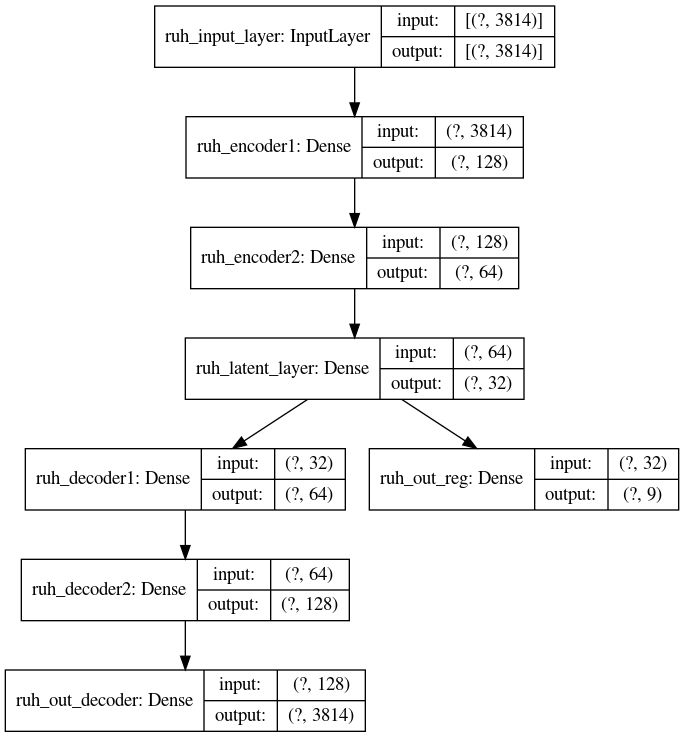

In [20]:
tf.keras.utils.plot_model(model=reg_stacked_ae
                             ,to_file='reg_stacked_ae.png'
                             ,show_shapes=True
#                              ,show_dtype = True
                             , expand_nested=True
                             )

In [19]:
 ### Regression Stacked AE (WITH SHARED LAYER FOR REGRESSION)
import matplotlib.pyplot as plt


## corr coeff:
from tensorflow.keras import backend as K
import scipy as sp
def func_correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt( tf.multiply(  K.sum(K.square(xm)), K.sum(K.square(ym))  ) )
    r = r_num / r_den
#     r = sp.stats.pearsonr(x.numpy(),y.numpy())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

### end corr coeff



## create root log dir for TensorBoard
import os
root_logdir = os.path.join(os.curdir, 'ruh_rootdir_logs')

def get_run_logdir(subdir_name):
    import time
    run_id = time.strftime(subdir_name+'_%Y_%m_%d_%H_%M_%S')
    return os.path.join(root_logdir, run_id)

ruh_run_logdir = get_run_logdir(subdir_name = 'Rreg_stacked_ae')


my_batch_size = 128
my_lr = .001
my_ngenes_train = df_trial_train.shape[1]
my_ncube_train = df_trial_train[~mask].shape[0]
nunit_output = xyz_coor_trial_train.shape[1]

my_nepochs = 100

n_neurons = my_ngenes_train # #not iterable
n_neurons_latent = 32
n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)



## input layer»
my_Input_layer = kr.layers.Input(shape=(n_neurons,), name = 'ruh_input_layer') #shape=df_trial_train.shape[1:])

## encoder:
encoder_layer = kr.layers.Dense(n_neurons1, activation = 'relu', name = 'ruh_encoder1')(my_Input_layer)
encoder_layer = kr.layers.Dense(n_neurons2, activation = 'relu', name = 'ruh_encoder2')(encoder_layer)

## latent space
latent_layer = kr.layers.Dense(n_neurons_latent, activation = 'relu', name = 'ruh_latent_layer')(encoder_layer)

## decoder:
#decoder_input = kr.layers.Input(shape=(n_neurons_latent,))
decoder_layer = kr.layers.Dense(n_neurons2 , activation = 'relu', name = 'ruh_decoder1')(latent_layer) 
decoder_layer = kr.layers.Dense(n_neurons1 , activation = 'relu', name = 'ruh_decoder2')(decoder_layer)
decoder_layer = kr.layers.Dense(n_neurons  , activation = 'relu', name = 'ruh_out_decoder')(decoder_layer)


## regression:
reg_layer = kr.layers.Dense(nunit_output, activation = 'relu', name = 'ruh_out_reg')(latent_layer)## sigmoid if b/w [0,1]



# my_outputs = kr.layers.Dense(n_neurons)(decoder_layer)

## stacked ae
reg_stacked_ae = kr.models.Model(my_Input_layer, [decoder_layer, reg_layer]) #kr.models.Model(encoder_layer, my_outputs)
reg_stacked_ae.summary()

## optimization + loss + metrics
myoptimizer = kr.optimizers.SGD(lr = my_lr, momentum=.9, nesterov=True) #, momentum=.01)
myoptimizer = kr.optimizers.Adam(lr = my_lr, beta_1=.9, beta_2=.999)

reg_stacked_ae.compile(loss ={'ruh_out_reg': 'mse' , 'ruh_out_decoder':'mse'}
                       , loss_weights = {'ruh_out_decoder': .001, 'ruh_out_reg':.1 }
                       , optimizer = myoptimizer, metrics= {'ruh_out_decoder':[func_correlation_coefficient], 'ruh_out_reg':[func_correlation_coefficient]}
                      )


print('#samples/epoch = ', df_trial_train[~mask].shape[0]/my_batch_size, '\n')

earlystopping_RegStackedAE = kr.callbacks.EarlyStopping(patience=10, restore_best_weights=True)                   
tensorboard_RegStackedAE = kr.callbacks.TensorBoard(ruh_run_logdir)
checkpoint_RegStackedAE = kr.callbacks.ModelCheckpoint('saved_models/ruh_best_VAE.hd5', save_best_only=True)


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ruh_input_layer (InputLayer)    [(None, 3814)]       0                                            
__________________________________________________________________________________________________
ruh_encoder1 (Dense)            (None, 128)          488320      ruh_input_layer[0][0]            
__________________________________________________________________________________________________
ruh_encoder2 (Dense)            (None, 64)           8256        ruh_encoder1[0][0]               
__________________________________________________________________________________________________
ruh_latent_layer (Dense)        (None, 32)           2080        ruh_encoder2[0][0]               
_______________________________________________________________________________________

INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.__init__.<locals>.permutation at 0x7f50dc1fec20>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int64>,)
    kwargs: {}

Converted call: <function TensorLikeDataAdapter.__init__.<locals>.permutation at 0x7f50dc1fec20>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int64>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.__init__.<locals>.slice_batch_indices at 0x7f50dc1fe8c0>
    args: (<tf.Tensor 'args_0:0' shape=(54429,) dtype=int64>,)
    kwargs: {}

Converted call: <function TensorLikeDataAdapter.__init__.<locals>.slice_batch_indices at 0x7f50dc1fe8c0>
    args: (<tf.Tensor 'args_0:0' shape=(54429,) dtype=int64>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.slice_inputs.<locals>.grab_batch at 0x7f50dc1fe0e0>
    args: (<tf.Tensor 'args_0:0' shape=(None,) dtype=int64>, ({'ruh_input_layer': <tf.Tensor 'args_1:0' shape=(54429, 3814) dtype=float64>}, {'r

Converted call: <bound method Reduce.update_state of <tensorflow.python.keras.metrics.Mean object at 0x7f50dc9b9710>>
    args: (<tf.Tensor 'mean_squared_error/weighted_loss/value:0' shape=() dtype=float32>,)
    kwargs: {'sample_weight': <tf.Tensor 'strided_slice:0' shape=() dtype=int32>}

INFO:tensorflow:Converted call: <bound method LossFunctionWrapper.call of <tensorflow.python.keras.losses.LossFunctionWrapper object at 0x7f50d7c11b50>>
    args: (<tf.Tensor 'Cast_2:0' shape=(None, 9) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_reg/Relu:0' shape=(None, 9) dtype=float32>)
    kwargs: {}

Converted call: <bound method LossFunctionWrapper.call of <tensorflow.python.keras.losses.LossFunctionWrapper object at 0x7f50d7c11b50>>
    args: (<tf.Tensor 'Cast_2:0' shape=(None, 9) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_reg/Relu:0' shape=(None, 9) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <bound method Reduce.update_state of <tensorflow.python.keras.metrics.

Converted call: functools.partial(<bound method OptimizerV2._distributed_apply of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f50d9812910>>, apply_state={('/job:localhost/replica:0/task:0/device:CPU:0', tf.float32): {'lr_t': <tf.Tensor 'Adam/Identity:0' shape=() dtype=float32>, 'lr': <tf.Tensor 'Adam/mul:0' shape=() dtype=float32>, 'epsilon': <tf.Tensor 'Adam/Const:0' shape=() dtype=float32>, 'beta_1_t': <tf.Tensor 'Adam/Identity_1:0' shape=() dtype=float32>, 'beta_1_power': <tf.Tensor 'Adam/Pow:0' shape=() dtype=float32>, 'one_minus_beta_1_t': <tf.Tensor 'Adam/sub_2:0' shape=() dtype=float32>, 'beta_2_t': <tf.Tensor 'Adam/Identity_2:0' shape=() dtype=float32>, 'beta_2_power': <tf.Tensor 'Adam/Pow_1:0' shape=() dtype=float32>, 'one_minus_beta_2_t': <tf.Tensor 'Adam/sub_3:0' shape=() dtype=float32>}})
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7f50dc793f50>, ((<tf.Tensor 'gradient_tape/functional_3/ruh_encoder1/MatMu

Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x7f50d866af80>
    args: (<tf.Variable 'ruh_encoder1/kernel:0' shape=(3814, 128) dtype=float32>, <tf.Tensor 'gradient_tape/functional_3/ruh_encoder1/MatMul:0' shape=(3814, 128) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x7f50d866af80>
    args: (<tf.Variable 'ruh_encoder1/bias:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/functional_3/ruh_encoder1/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>)
    kwargs: {}

Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x7f50d866af80>
    args: (<tf.Variable 'ruh_encoder1/bias:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/functional_3/ruh_encoder1/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_app

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Converted call: <bound method MeanMetricWrapper.update_state of <tensorflow.python.keras.metrics.MeanMetricWrapper object at 0x7f50d885abd0>>
    args: (<tf.Tensor 'Cast_5:0' shape=(None, 3814) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_decoder/Relu:0' shape=(None, 3814) dtype=float32>)
    kwargs: {'sample_weight': None}

Converted call: <bound method MeanMetricWrapper.update_state of <tensorflow.python.keras.metrics.MeanMetricWrapper object at 0x7f50d885abd0>>
    args: (<tf.Tensor 'Cast_5:0' shape=(None, 3814) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_decoder/Relu:0' shape=(None, 3814) dtype=float32>)
    kwargs: {'sample_weight': None}

INFO:tensorflow:Converted call: <function func_correlation_coefficient at 0x7f50dc44c680>
    args: (<tf.Tensor 'Cast_5:0' shape=(None, 3814) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_decoder/Relu:0' shape=(None, 3814) dtype=float32>)
    kwargs: {}

Converted call: <function func_correlation_coefficient at 0x7f50

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Converted call: <bound method MeanMetricWrapper.update_state of <tensorflow.python.keras.metrics.MeanMetricWrapper object at 0x7f50dbff31d0>>
    args: (<tf.Tensor 'Cast_7:0' shape=(None, 9) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_reg/Relu:0' shape=(None, 9) dtype=float32>)
    kwargs: {'sample_weight': None}

Converted call: <bound method MeanMetricWrapper.update_state of <tensorflow.python.keras.metrics.MeanMetricWrapper object at 0x7f50dbff31d0>>
    args: (<tf.Tensor 'Cast_7:0' shape=(None, 9) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_reg/Relu:0' shape=(None, 9) dtype=float32>)
    kwargs: {'sample_weight': None}

INFO:tensorflow:Converted call:

Converted call: <function OptimizerV2._aggregate_gradients.<locals>.all_reduce_fn at 0x7f50d7aea950>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7f50dc793f50>, ((<tf.Tensor 'gradient_tape/functional_3/ruh_encoder1/MatMul:0' shape=(3814, 128) dtype=float32>, <tf.Variable 'ruh_encoder1/kernel:0' shape=(3814, 128) dtype=float32>), (<tf.Tensor 'gradient_tape/functional_3/ruh_encoder1/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Variable 'ruh_encoder1/bias:0' shape=(128,) dtype=float32>), (<tf.Tensor 'gradient_tape/functional_3/ruh_encoder2/MatMul_1:0' shape=(128, 64) dtype=float32>, <tf.Variable 'ruh_encoder2/kernel:0' shape=(128, 64) dtype=float32>), (<tf.Tensor 'gradient_tape/functional_3/ruh_encoder2/BiasAdd/BiasAddGrad:0' shape=(64,) dtype=float32>, <tf.Variable 'ruh_encoder2/bias:0' shape=(64,) dtype=float32>), (<tf.Tensor 'gradient_tape/functional_3/ruh_latent_layer/MatMul_1:0' shape=(64, 32) dtype=float32>, <tf.Variable

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Converted call: functools.partial(<bound method OptimizerV2._distributed_apply of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f50d9812910>>, apply_state={('/job:localhost/replica:0/task:0/device:CPU:0', tf.float32): {'lr_t': <tf.Tensor 'Adam/Identity:0' shape=() dtype=float32>, 'lr': <tf.Tensor 'Adam/mul:0' shape=() dtype=float32>, 'epsilon': <tf.Tensor 'Adam/Const:0' shape=() dtype=float32>, 'beta_1_t': <tf.Tensor 'Adam/Identity_1:0' shape=() dtype=float32>, 'beta_1_power': <tf.Tensor 'Adam/Pow:0' shape=() dtype=float32>, 'one_minus_beta_1_t': <tf.Tensor 'Adam/sub_2:0' shape=() dtype=float32>, 'beta_2_t': <tf.Tensor 'Adam/Identity_2:0' shape=() dtype=float32>, 'beta_2_power': <tf.Tensor 'Adam/Pow_1:0' shape=() dtype=float32>, 'one_minus_beta_2_t': <tf.Tensor 'Adam/sub_3:0' shape=() dtype=float32>}})
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7f50dc793f50>, ((<tf.Tensor 'gradient_tape/functional_3/ru

Converted call: <bound method OptimizerV2._distributed_apply of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f50d9812910>>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7f50dc793f50>, ((<tf.Tensor 'gradient_tape/functional_3/ruh_encoder1/MatMul:0' shape=(3814, 128) dtype=float32>, <tf.Variable 'ruh_encoder1/kernel:0' shape=(3814, 128) dtype=float32>), (<tf.Tensor 'gradient_tape/functional_3/ruh_encoder1/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Variable 'ruh_encoder1/bias:0' shape=(128,) dtype=float32>), (<tf.Tensor 'gradient_tape/functional_3/ruh_encoder2/MatMul_1:0' shape=(128, 64) dtype=float32>, <tf.Variable 'ruh_encoder2/kernel:0' shape=(128, 64) dtype=float32>), (<tf.Tensor 'gradient_tape/functional_3/ruh_encoder2/BiasAdd/BiasAddGrad:0' shape=(64,) dtype=float32>, <tf.Variable 'ruh_encoder2/bias:0' shape=(64,) dtype=float32>), (<tf.Tensor 'gradient_tape/functional_3/ruh_latent_layer/MatMul_1:0' shape

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x7f50db702290>
    args: (<tf.Variable 'ruh_decoder2/kernel:0' shape=(64, 128) dtype=float32>, <tf.Tensor 'gradient_tape/functional_3/ruh_decoder2/MatMul_1:0' shape=(64, 128) dtype=float32>)
    kwargs: {}

Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x7f50db702290>
    args: (<tf.Variable 'ruh_decoder2/kernel:0' shape=(64, 128) dtype=float32>, <tf.Tensor 'gradient_tape/functional_3/ruh_decoder2/MatMul_1:0' shape=(64, 128) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x7f50db702290>
    args: (<tf.Variable 'ruh_decoder2/bias:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/functional_3/ruh_decoder2/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>)
    kwargs: {}

Converted call: <function OptimizerV2._distributed_apply.<l

Converted call: <bound method Reduce.update_state of <tensorflow.python.keras.metrics.Mean object at 0x7f50dc9b9710>>
    args: (<tf.Tensor 'mean_squared_error/weighted_loss/value:0' shape=() dtype=float32>,)
    kwargs: {'sample_weight': <tf.Tensor 'strided_slice:0' shape=() dtype=int32>}

INFO:tensorflow:Converted call: <bound method LossFunctionWrapper.call of <tensorflow.python.keras.losses.LossFunctionWrapper object at 0x7f50d7c11b50>>
    args: (<tf.Tensor 'Cast_2:0' shape=(None, 9) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_reg/Relu:0' shape=(None, 9) dtype=float32>)
    kwargs: {}

Converted call: <bound method LossFunctionWrapper.call of <tensorflow.python.keras.losses.LossFunctionWrapper object at 0x7f50d7c11b50>>
    args: (<tf.Tensor 'Cast_2:0' shape=(None, 9) dtype=float32>, <tf.Tensor 'functional_3/ruh_out_reg/Relu:0' shape=(None, 9) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Converted call: <bound method Reduce.update_state of <tensorflow.python.keras.metrics.

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d8794b00>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d8794b00>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

INFO:tensorflow:<function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d8794b00> is not cached for subkey ConversionOptions[{}]
<function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d8794b00> is not cached for subkey ConversionOptions[{}]
INFO:tensorflow:Error transforming entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d8794b00>
Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensor

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 7s 17ms/step - loss: 0.0080 - ruh_out_decoder_loss: 0.7732 - ruh_out_reg_loss: 0.0723 - ruh_out_decoder_func_correlation_coefficient: 0.5351 - ruh_out_reg_func_correlation_coefficient: 0.8011 - val_loss: 0.0045 - val_ruh_out_decoder_loss: 0.7333 - val_ruh_out_reg_loss: 0.0380 - val_ruh_out_decoder_func_correlation_coefficient: 0.5906 - val_ruh_out_reg_func_correlation_coefficient: 0.8541
Epoch 2/100
421/426 [============================>.] - ETA: 0s - loss: 0.0044 - ruh_out_decoder_loss: 0.7135 - ruh_out_reg_loss: 0.0373 - ruh_out_decoder_func_correlation_coefficient: 0.6162 - ruh_out_reg_func_correlation_coefficient: 0.8737INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d87947a0>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function can

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 6s 13ms/step - loss: 0.0044 - ruh_out_decoder_loss: 0.7134 - ruh_out_reg_loss: 0.0373 - ruh_out_decoder_func_correlation_coefficient: 0.6164 - ruh_out_reg_func_correlation_coefficient: 0.8737 - val_loss: 0.0044 - val_ruh_out_decoder_loss: 0.7002 - val_ruh_out_reg_loss: 0.0372 - val_ruh_out_decoder_func_correlation_coefficient: 0.6330 - val_ruh_out_reg_func_correlation_coefficient: 0.8644
Epoch 3/100
421/426 [============================>.] - ETA: 0s - loss: 0.0043 - ruh_out_decoder_loss: 0.6880 - ruh_out_reg_loss: 0.0363 - ruh_out_decoder_func_correlation_coefficient: 0.6474 - ruh_out_reg_func_correlation_coefficient: 0.8771INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d8cae4d0>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function can

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0043 - ruh_out_decoder_loss: 0.6879 - ruh_out_reg_loss: 0.0363 - ruh_out_decoder_func_correlation_coefficient: 0.6475 - ruh_out_reg_func_correlation_coefficient: 0.8771 - val_loss: 0.0043 - val_ruh_out_decoder_loss: 0.6813 - val_ruh_out_reg_loss: 0.0359 - val_ruh_out_decoder_func_correlation_coefficient: 0.6557 - val_ruh_out_reg_func_correlation_coefficient: 0.8618
Epoch 4/100
421/426 [============================>.] - ETA: 0s - loss: 0.0043 - ruh_out_decoder_loss: 0.6719 - ruh_out_reg_loss: 0.0359 - ruh_out_decoder_func_correlation_coefficient: 0.6664 - ruh_out_reg_func_correlation_coefficient: 0.8786INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d8791710>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function can

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0043 - ruh_out_decoder_loss: 0.6718 - ruh_out_reg_loss: 0.0359 - ruh_out_decoder_func_correlation_coefficient: 0.6665 - ruh_out_reg_func_correlation_coefficient: 0.8785 - val_loss: 0.0043 - val_ruh_out_decoder_loss: 0.6671 - val_ruh_out_reg_loss: 0.0359 - val_ruh_out_decoder_func_correlation_coefficient: 0.6718 - val_ruh_out_reg_func_correlation_coefficient: 0.8599
Epoch 5/100
425/426 [============================>.] - ETA: 0s - loss: 0.0042 - ruh_out_decoder_loss: 0.6580 - ruh_out_reg_loss: 0.0357 - ruh_out_decoder_func_correlation_coefficient: 0.6826 - ruh_out_reg_func_correlation_coefficient: 0.8792INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50dbf8c0e0>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function can

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 6s 13ms/step - loss: 0.0042 - ruh_out_decoder_loss: 0.6580 - ruh_out_reg_loss: 0.0357 - ruh_out_decoder_func_correlation_coefficient: 0.6826 - ruh_out_reg_func_correlation_coefficient: 0.8793 - val_loss: 0.0042 - val_ruh_out_decoder_loss: 0.6540 - val_ruh_out_reg_loss: 0.0354 - val_ruh_out_decoder_func_correlation_coefficient: 0.6863 - val_ruh_out_reg_func_correlation_coefficient: 0.8628
Epoch 6/100
425/426 [============================>.] - ETA: 0s - loss: 0.0042 - ruh_out_decoder_loss: 0.6453 - ruh_out_reg_loss: 0.0356 - ruh_out_decoder_func_correlation_coefficient: 0.6971 - ruh_out_reg_func_correlation_coefficient: 0.8797INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50dc95fdd0>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function can

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0042 - ruh_out_decoder_loss: 0.6453 - ruh_out_reg_loss: 0.0356 - ruh_out_decoder_func_correlation_coefficient: 0.6972 - ruh_out_reg_func_correlation_coefficient: 0.8796 - val_loss: 0.0042 - val_ruh_out_decoder_loss: 0.6422 - val_ruh_out_reg_loss: 0.0353 - val_ruh_out_decoder_func_correlation_coefficient: 0.7006 - val_ruh_out_reg_func_correlation_coefficient: 0.8660
Epoch 7/100
426/426 [==============================] - 5s 11ms/step - loss: 0.0042 - ruh_out_decoder_loss: 0.6363 - ruh_out_reg_loss: 0.0355 - ruh_out_decoder_func_correlation_coefficient: 0.7071 - ruh_out_reg_func_correlation_coefficient: 0.8802 - val_loss: 0.0042 - val_ruh_out_decoder_loss: 0.6341 - val_ruh_out_reg_loss: 0.0353 - val_ruh_out_decoder_func_correlation_coefficient: 0.7089 - val_ruh_out_reg_func_correlation_coefficient: 0.8615
Epoch 8/100
423/426 [===========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0042 - ruh_out_decoder_loss: 0.6292 - ruh_out_reg_loss: 0.0354 - ruh_out_decoder_func_correlation_coefficient: 0.7150 - ruh_out_reg_func_correlation_coefficient: 0.8803 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6288 - val_ruh_out_reg_loss: 0.0352 - val_ruh_out_decoder_func_correlation_coefficient: 0.7162 - val_ruh_out_reg_func_correlation_coefficient: 0.8677
Epoch 9/100
426/426 [==============================] - 5s 11ms/step - loss: 0.0042 - ruh_out_decoder_loss: 0.6246 - ruh_out_reg_loss: 0.0353 - ruh_out_decoder_func_correlation_coefficient: 0.7201 - ruh_out_reg_func_correlation_coefficient: 0.8806 - val_loss: 0.0042 - val_ruh_out_decoder_loss: 0.6255 - val_ruh_out_reg_loss: 0.0360 - val_ruh_out_decoder_func_correlation_coefficient: 0.7192 - val_ruh_out_reg_func_correlation_coefficient: 0.8723
Epoch 10/100
421/426 [==========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.6205 - ruh_out_reg_loss: 0.0353 - ruh_out_decoder_func_correlation_coefficient: 0.7247 - ruh_out_reg_func_correlation_coefficient: 0.8807 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6207 - val_ruh_out_reg_loss: 0.0352 - val_ruh_out_decoder_func_correlation_coefficient: 0.7235 - val_ruh_out_reg_func_correlation_coefficient: 0.8663
Epoch 11/100
424/426 [============================>.] - ETA: 0s - loss: 0.0041 - ruh_out_decoder_loss: 0.6174 - ruh_out_reg_loss: 0.0353 - ruh_out_decoder_func_correlation_coefficient: 0.7281 - ruh_out_reg_func_correlation_coefficient: 0.8808INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50dcff97a0>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function ca

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.6174 - ruh_out_reg_loss: 0.0353 - ruh_out_decoder_func_correlation_coefficient: 0.7281 - ruh_out_reg_func_correlation_coefficient: 0.8808 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6181 - val_ruh_out_reg_loss: 0.0351 - val_ruh_out_decoder_func_correlation_coefficient: 0.7270 - val_ruh_out_reg_func_correlation_coefficient: 0.8631
Epoch 12/100
422/426 [============================>.] - ETA: 0s - loss: 0.0041 - ruh_out_decoder_loss: 0.6146 - ruh_out_reg_loss: 0.0352 - ruh_out_decoder_func_correlation_coefficient: 0.7313 - ruh_out_reg_func_correlation_coefficient: 0.8811INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d822cb90>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function ca

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 6s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.6146 - ruh_out_reg_loss: 0.0352 - ruh_out_decoder_func_correlation_coefficient: 0.7313 - ruh_out_reg_func_correlation_coefficient: 0.8811 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6146 - val_ruh_out_reg_loss: 0.0350 - val_ruh_out_decoder_func_correlation_coefficient: 0.7312 - val_ruh_out_reg_func_correlation_coefficient: 0.8671
Epoch 13/100
421/426 [============================>.] - ETA: 0s - loss: 0.0041 - ruh_out_decoder_loss: 0.6118 - ruh_out_reg_loss: 0.0352 - ruh_out_decoder_func_correlation_coefficient: 0.7344 - ruh_out_reg_func_correlation_coefficient: 0.8810INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d822c560>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function ca

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.6117 - ruh_out_reg_loss: 0.0352 - ruh_out_decoder_func_correlation_coefficient: 0.7345 - ruh_out_reg_func_correlation_coefficient: 0.8812 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6125 - val_ruh_out_reg_loss: 0.0349 - val_ruh_out_decoder_func_correlation_coefficient: 0.7333 - val_ruh_out_reg_func_correlation_coefficient: 0.8655
Epoch 14/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.6093 - ruh_out_reg_loss: 0.0351 - ruh_out_decoder_func_correlation_coefficient: 0.7373 - ruh_out_reg_func_correlation_coefficient: 0.8814 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6103 - val_ruh_out_reg_loss: 0.0353 - val_ruh_out_decoder_func_correlation_coefficient: 0.7362 - val_ruh_out_reg_func_correlation_coefficient: 0.8671
Epoch 15/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.6038 - ruh_out_reg_loss: 0.0351 - ruh_out_decoder_func_correlation_coefficient: 0.7430 - ruh_out_reg_func_correlation_coefficient: 0.8815 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6051 - val_ruh_out_reg_loss: 0.0348 - val_ruh_out_decoder_func_correlation_coefficient: 0.7420 - val_ruh_out_reg_func_correlation_coefficient: 0.8670
Epoch 18/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.6027 - ruh_out_reg_loss: 0.0350 - ruh_out_decoder_func_correlation_coefficient: 0.7441 - ruh_out_reg_func_correlation_coefficient: 0.8817 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6042 - val_ruh_out_reg_loss: 0.0349 - val_ruh_out_decoder_func_correlation_coefficient: 0.7426 - val_ruh_out_reg_func_correlation_coefficient: 0.8642
Epoch 19/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5994 - ruh_out_reg_loss: 0.0350 - ruh_out_decoder_func_correlation_coefficient: 0.7476 - ruh_out_reg_func_correlation_coefficient: 0.8818 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6012 - val_ruh_out_reg_loss: 0.0348 - val_ruh_out_decoder_func_correlation_coefficient: 0.7445 - val_ruh_out_reg_func_correlation_coefficient: 0.8682
Epoch 22/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5986 - ruh_out_reg_loss: 0.0350 - ruh_out_decoder_func_correlation_coefficient: 0.7485 - ruh_out_reg_func_correlation_coefficient: 0.8819 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.6003 - val_ruh_out_reg_loss: 0.0348 - val_ruh_out_decoder_func_correlation_coefficient: 0.7468 - val_ruh_out_reg_func_correlation_coefficient: 0.8635
Epoch 23/100
425/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5978 - ruh_out_reg_loss: 0.0350 - ruh_out_decoder_func_correlation_coefficient: 0.7492 - ruh_out_reg_func_correlation_coefficient: 0.8818 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5999 - val_ruh_out_reg_loss: 0.0348 - val_ruh_out_decoder_func_correlation_coefficient: 0.7464 - val_ruh_out_reg_func_correlation_coefficient: 0.8655
Epoch 24/100
420/426 [============================>.] - ETA: 0s - loss: 0.0041 - ruh_out_decoder_loss: 0.5971 - ruh_out_reg_loss: 0.0350 - ruh_out_decoder_func_correlation_coefficient: 0.7500 - ruh_out_reg_func_correlation_coefficient: 0.8820INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50db5b6440>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function ca

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5970 - ruh_out_reg_loss: 0.0350 - ruh_out_decoder_func_correlation_coefficient: 0.7501 - ruh_out_reg_func_correlation_coefficient: 0.8819 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5980 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7488 - val_ruh_out_reg_func_correlation_coefficient: 0.8658
Epoch 25/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5954 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7521 - ruh_out_reg_func_correlation_coefficient: 0.8819 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5970 - val_ruh_out_reg_loss: 0.0348 - val_ruh_out_decoder_func_correlation_coefficient: 0.7504 - val_ruh_out_reg_func_correlation_coefficient: 0.8675
Epoch 26/100
421/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5947 - ruh_out_reg_loss: 0.0350 - ruh_out_decoder_func_correlation_coefficient: 0.7527 - ruh_out_reg_func_correlation_coefficient: 0.8819 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5964 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7499 - val_ruh_out_reg_func_correlation_coefficient: 0.8670
Epoch 27/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5940 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7534 - ruh_out_reg_func_correlation_coefficient: 0.8821 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5956 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7513 - val_ruh_out_reg_func_correlation_coefficient: 0.8657
Epoch 28/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5923 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7553 - ruh_out_reg_func_correlation_coefficient: 0.8821 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5943 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7532 - val_ruh_out_reg_func_correlation_coefficient: 0.8656
Epoch 31/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5919 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7556 - ruh_out_reg_func_correlation_coefficient: 0.8823 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5940 - val_ruh_out_reg_loss: 0.0348 - val_ruh_out_decoder_func_correlation_coefficient: 0.7533 - val_ruh_out_reg_func_correlation_coefficient: 0.8687
Epoch 32/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5906 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7572 - ruh_out_reg_func_correlation_coefficient: 0.8821 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5925 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7545 - val_ruh_out_reg_func_correlation_coefficient: 0.8668
Epoch 35/100
420/426 [============================>.] - ETA: 0s - loss: 0.0041 - ruh_out_decoder_loss: 0.5901 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7577 - ruh_out_reg_func_correlation_coefficient: 0.8821INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50d89fd290>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function ca

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5901 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7577 - ruh_out_reg_func_correlation_coefficient: 0.8823 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5919 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7573 - val_ruh_out_reg_func_correlation_coefficient: 0.8679
Epoch 36/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5895 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7584 - ruh_out_reg_func_correlation_coefficient: 0.8823 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5914 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7561 - val_ruh_out_reg_func_correlation_coefficient: 0.8658
Epoch 37/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5888 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7590 - ruh_out_reg_func_correlation_coefficient: 0.8823 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5905 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7574 - val_ruh_out_reg_func_correlation_coefficient: 0.8670
Epoch 39/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5885 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7594 - ruh_out_reg_func_correlation_coefficient: 0.8824 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5904 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7576 - val_ruh_out_reg_func_correlation_coefficient: 0.8670
Epoch 40/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5864 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7618 - ruh_out_reg_func_correlation_coefficient: 0.8825 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5883 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7591 - val_ruh_out_reg_func_correlation_coefficient: 0.8656
Epoch 45/100
425/426 [============================>.] - ETA: 0s - loss: 0.0041 - ruh_out_decoder_loss: 0.5860 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7622 - ruh_out_reg_func_correlation_coefficient: 0.8825INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50db47d950>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function ca

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5860 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7622 - ruh_out_reg_func_correlation_coefficient: 0.8825 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5878 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7597 - val_ruh_out_reg_func_correlation_coefficient: 0.8680
Epoch 46/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5860 - ruh_out_reg_loss: 0.0349 - ruh_out_decoder_func_correlation_coefficient: 0.7623 - ruh_out_reg_func_correlation_coefficient: 0.8823 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5878 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7604 - val_ruh_out_reg_func_correlation_coefficient: 0.8685
Epoch 47/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5853 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7630 - ruh_out_reg_func_correlation_coefficient: 0.8824 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5871 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7612 - val_ruh_out_reg_func_correlation_coefficient: 0.8675
Epoch 49/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5851 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7632 - ruh_out_reg_func_correlation_coefficient: 0.8824 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5870 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7609 - val_ruh_out_reg_func_correlation_coefficient: 0.8677
Epoch 50/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 6s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5841 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7643 - ruh_out_reg_func_correlation_coefficient: 0.8824 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5859 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7617 - val_ruh_out_reg_func_correlation_coefficient: 0.8677
Epoch 54/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5837 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7649 - ruh_out_reg_func_correlation_coefficient: 0.8825 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5861 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7623 - val_ruh_out_reg_func_correlation_coefficient: 0.8700
Epoch 55/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5828 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7660 - ruh_out_reg_func_correlation_coefficient: 0.8825 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5845 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7640 - val_ruh_out_reg_func_correlation_coefficient: 0.8686
Epoch 59/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5826 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7660 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5847 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7638 - val_ruh_out_reg_func_correlation_coefficient: 0.8660
Epoch 60/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 12ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5812 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7678 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5835 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7654 - val_ruh_out_reg_func_correlation_coefficient: 0.8660
Epoch 65/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5811 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7679 - ruh_out_reg_func_correlation_coefficient: 0.8825 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5832 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7649 - val_ruh_out_reg_func_correlation_coefficient: 0.8688
Epoch 66/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5807 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7683 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5828 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7658 - val_ruh_out_reg_func_correlation_coefficient: 0.8669
Epoch 69/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5806 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7685 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5832 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7659 - val_ruh_out_reg_func_correlation_coefficient: 0.8695
Epoch 70/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 6s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5800 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7691 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5819 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7674 - val_ruh_out_reg_func_correlation_coefficient: 0.8681
Epoch 75/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5799 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7692 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0041 - val_ruh_out_decoder_loss: 0.5822 - val_ruh_out_reg_loss: 0.0348 - val_ruh_out_decoder_func_correlation_coefficient: 0.7667 - val_ruh_out_reg_func_correlation_coefficient: 0.8668
Epoch 76/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5791 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7702 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5811 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7680 - val_ruh_out_reg_func_correlation_coefficient: 0.8661
Epoch 81/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5790 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7702 - ruh_out_reg_func_correlation_coefficient: 0.8827 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5810 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7679 - val_ruh_out_reg_func_correlation_coefficient: 0.8688
Epoch 82/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5783 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7710 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5802 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7681 - val_ruh_out_reg_func_correlation_coefficient: 0.8680
Epoch 85/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5782 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7711 - ruh_out_reg_func_correlation_coefficient: 0.8827 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5800 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7690 - val_ruh_out_reg_func_correlation_coefficient: 0.8676
Epoch 86/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5769 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7727 - ruh_out_reg_func_correlation_coefficient: 0.8827 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5792 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7703 - val_ruh_out_reg_func_correlation_coefficient: 0.8689
Epoch 92/100
425/426 [============================>.] - ETA: 0s - loss: 0.0041 - ruh_out_decoder_loss: 0.5770 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7726 - ruh_out_reg_func_correlation_coefficient: 0.8826INFO:tensorflow:Converted call: <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f50dc8979e0>
    args: ()
    kwargs: {'ruh_input_layer': <tf.Tensor 'ruh_input_layer:0' shape=(None, 3814) dtype=float32>}

Converted call: <function ca

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 5s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5770 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7727 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5789 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7708 - val_ruh_out_reg_func_correlation_coefficient: 0.8668
Epoch 93/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5768 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7729 - ruh_out_reg_func_correlation_coefficient: 0.8827 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5788 - val_ruh_out_reg_loss: 0.0347 - val_ruh_out_decoder_func_correlation_coefficient: 0.7713 - val_ruh_out_reg_func_correlation_coefficient: 0.8664
Epoch 94/100
426/426 [=========================

Traceback (most recent call last):
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 584, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/impl/conversion.py", line 119, in convert
    entity, program_ctx.options, program_ctx, custom_vars)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 412, in transform_function
    extra_locals)
  File "/avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/envs/ruhv3_neusom/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/transpiler.py", line 373, in 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 6s 13ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5764 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7734 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5784 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7714 - val_ruh_out_reg_func_correlation_coefficient: 0.8679
Epoch 97/100
426/426 [==============================] - 4s 10ms/step - loss: 0.0041 - ruh_out_decoder_loss: 0.5763 - ruh_out_reg_loss: 0.0348 - ruh_out_decoder_func_correlation_coefficient: 0.7734 - ruh_out_reg_func_correlation_coefficient: 0.8826 - val_loss: 0.0040 - val_ruh_out_decoder_loss: 0.5783 - val_ruh_out_reg_loss: 0.0346 - val_ruh_out_decoder_func_correlation_coefficient: 0.7716 - val_ruh_out_reg_func_correlation_coefficient: 0.8663
Epoch 98/100
426/426 [=========================

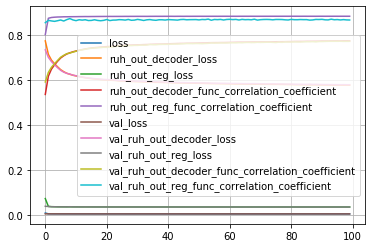

In [21]:
# import os
# os.environ['AUTOGRAPH_VERBOSITY'] = '1'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# import tensorflow as tf
history = reg_stacked_ae.fit( x = {'ruh_input_layer':df_trial_train[~mask] }
                             ,y = {'ruh_out_decoder':df_trial_train[~mask], 'ruh_out_reg':xyz_coor_trial_train[~mask]} #df_trial_train[~mask]#xyz_coor_trial_train[~mask]             
                             ,epochs=100              
                             ,validation_data=({'ruh_input_layer':df_trial_train[mask]}
                                               , {'ruh_out_decoder':df_trial_train[mask], 'ruh_out_reg':xyz_coor_trial_train[mask]}
                                              )#[df_trial_train[mask], df_trial_train[mask]]#(df_trial_train[mask], xyz_coor_trial_train[mask])              
                             
                             ,callbacks=[ earlystopping_RegStackedAE
                                     ,tensorboard_RegStackedAE
                                     ,checkpoint_RegStackedAE
                                    ] 
                             ,batch_size = my_batch_size
#                            , verbose = 1
                             #, validation_split = .2
                            )

pd.DataFrame(history.history).plot()
plt.grid(True)


mse_test_evalmethod_RegStackedAE = reg_stacked_ae.evaluate( x = {'ruh_input_layer':df_trial_test}
                                                           ,y = {'ruh_out_decoder':df_trial_test , 'ruh_out_reg':xyz_coor_trial_test}
                                                           )




print()
print( 'my_batch_size = ', my_batch_size)
print( 'my_lr = ', my_lr)
print( 'my_ngenes_train = ', my_ngenes_train)
print( 'my_ncube_train = ', my_ncube_train)
print()

print('MSE test for  FUNCATIONAL API RegStackedAE (.evaluate() method) =',mse_test_evalmethod_RegStackedAE)











[Jumpt to the beginning of ***REG Stacked AE with shared layer***](#reg_stacked_ae)




<a id='vae'></a>


## VAE reg 
[Link to: **### create trial version (=subset) of the SPATIAL XP for the ease of use**](#create_trial_version)


Model: "modelVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input.vae (InputLayer)          [(None, 3814)]       0                                            
__________________________________________________________________________________________________
enc1.vae (Dense)                (None, 128)          488320      input.vae[0][0]                  
__________________________________________________________________________________________________
enc2.vae (Dense)                (None, 64)           8256        enc1.vae[0][0]                   
__________________________________________________________________________________________________
z.mean.latent (Dense)           (None, 32)           2080        enc2.vae[0][0]                   
___________________________________________________________________________________________

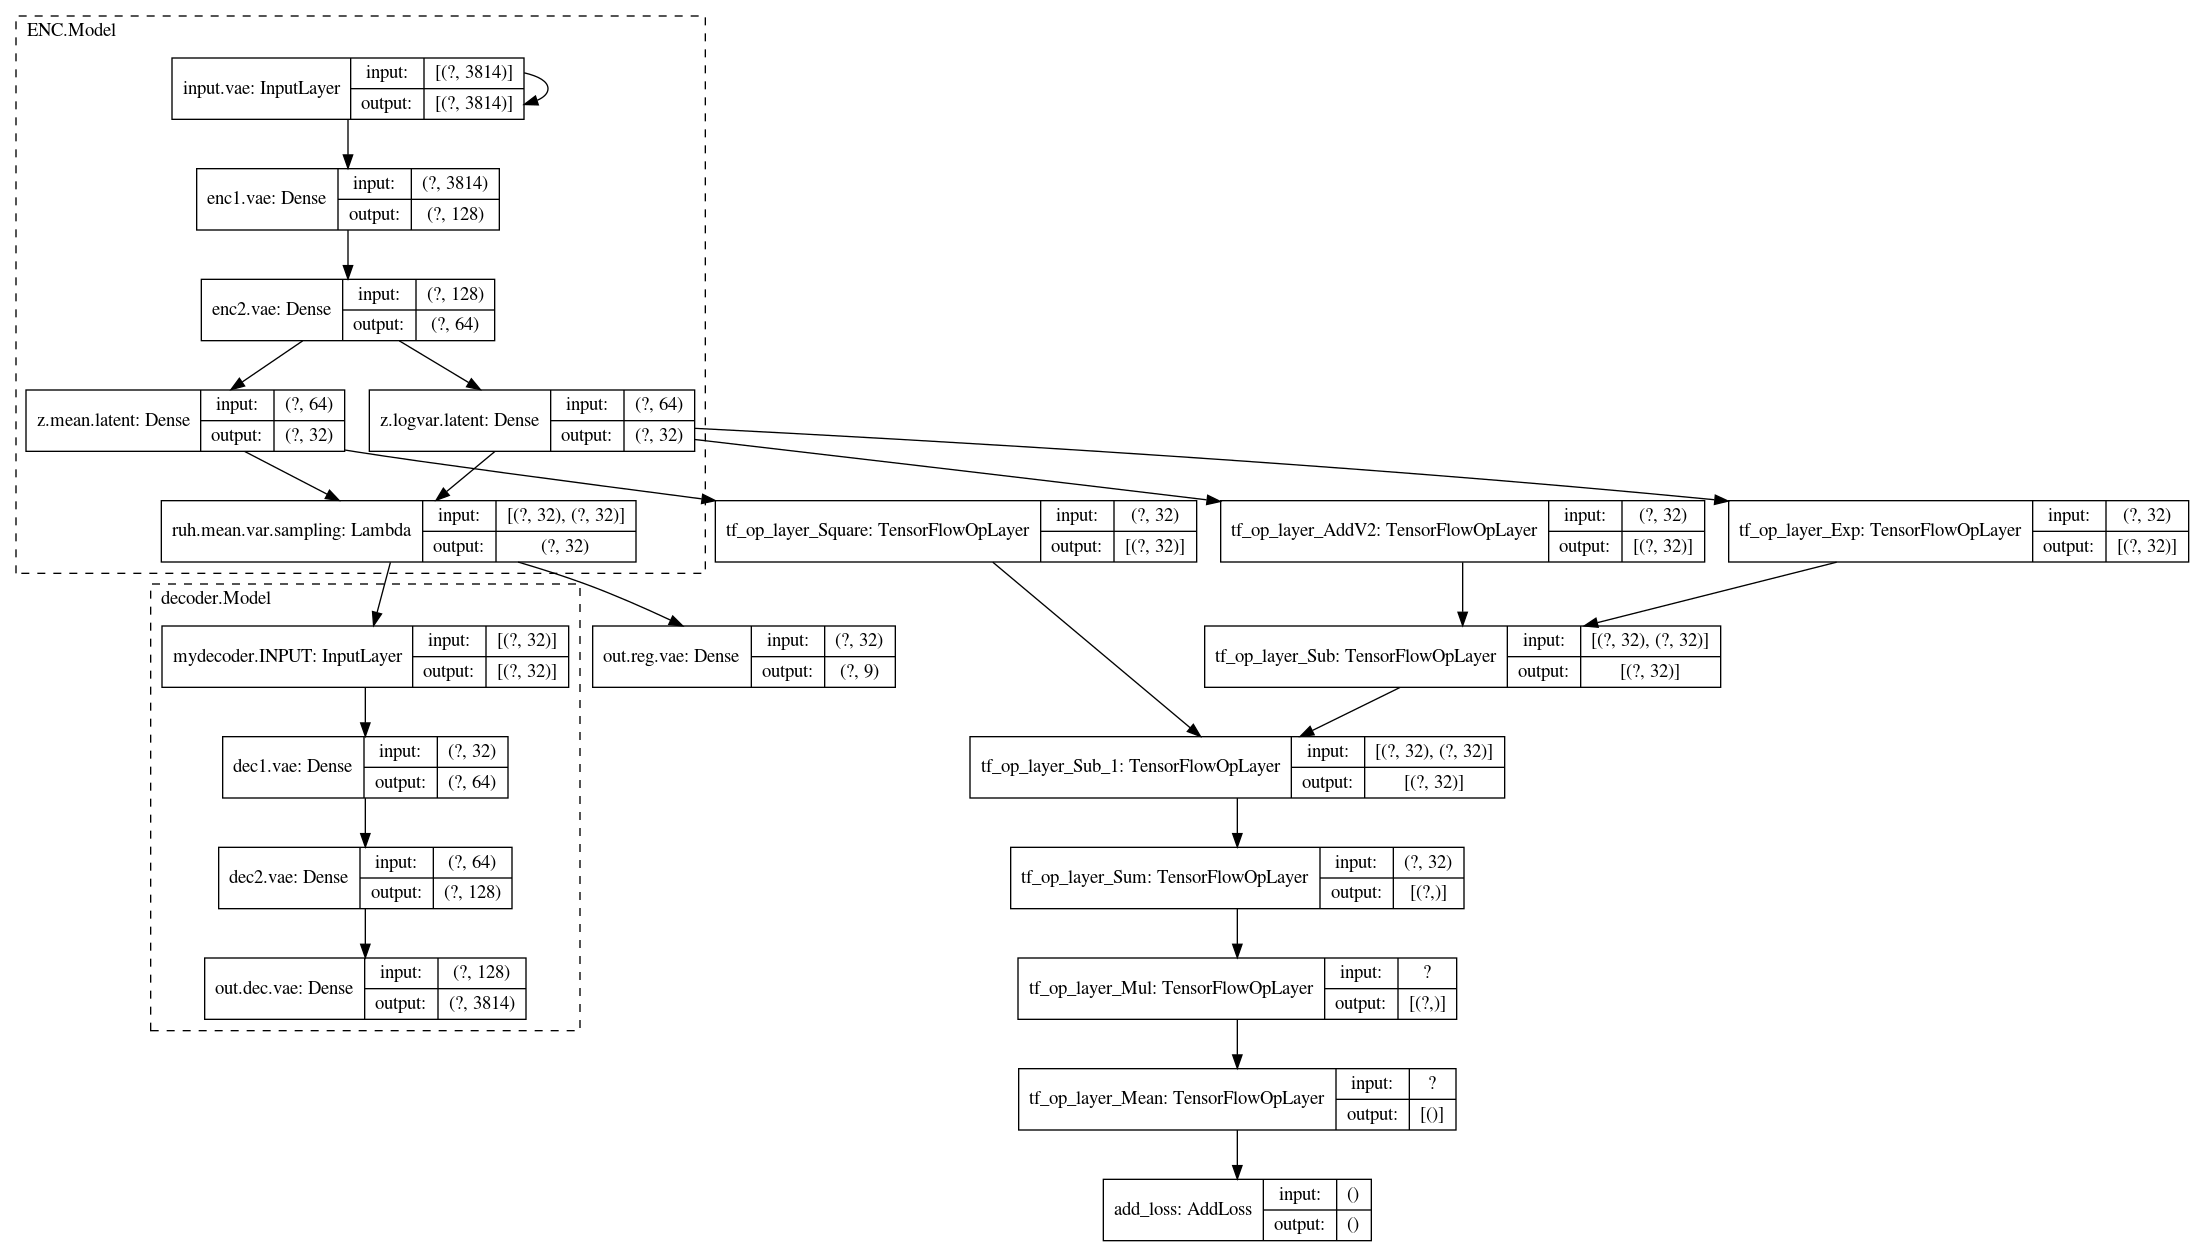

In [82]:
 ### VAE
    
    
import matplotlib.pyplot as plt


## corr coeff:
from tensorflow.keras import backend as K
import scipy as sp
def func_correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt( tf.multiply(  K.sum(K.square(xm)), K.sum(K.square(ym))  ) )
    r = r_num / r_den
#     r = sp.stats.pearsonr(x.numpy(),y.numpy())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

### end corr coeff



## create root log dir for TensorBoard
import os
root_logdir = os.path.join(os.curdir, 'ruh_rootdir_logs_vae')

def get_run_logdir(subdir_name):
    import time
    run_id = time.strftime(subdir_name+'_%Y_%m_%d_%H_%M_%S')
    return os.path.join(root_logdir, run_id)

ruh_run_logdir = get_run_logdir(subdir_name = 'SimpleVAE')


my_batch_size = 128
my_lr = .001
my_ngenes_train = df_trial_train.shape[1]
my_ncube_train = df_trial_train[~mask].shape[0]
nunit_output = xyz_coor_trial_train.shape[1]

my_nepochs = 100

n_neurons = my_ngenes_train # #not iterable
n_neurons_latent = 32
n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)




def ruh_sampling(args): ##chollet
    zmean, zlogvar = args
    myshape = ( K.shape(zmean)[0] , n_neurons_latent ) 
    epsilon = K.random_normal(  shape = myshape #A tuple of integers, the shape of tensor to create. 
                              , mean=0. #default
                              , stddev=1. #default
                             )
    return zmean + K.exp(zlogvar/2)*epsilon

class class_ruh_sampling(kr.layers.Layer): ##handson
    def call(self, my_sampling_inputs):
        zmean, zlogvar = my_sampling_inputs
        return zmean + K.random_normal(tf.shape(zlogvar))  * K.exp(zlogvar/2) 
        






## input layer»
my_Input_layer = kr.layers.Input(shape=(n_neurons,), name = 'input.vae') #shape=df_trial_train.shape[1:])


### for fun layer!!:
some_fun = kr.layers.Input(10, name = 'funnn')


## encoder:
encoder_layer = kr.layers.Dense(n_neurons1, activation = 'relu', name = 'enc1.vae')(my_Input_layer)
encoder_layer = kr.layers.Dense(n_neurons2, activation = 'relu', name = 'enc2.vae')(encoder_layer)


###  mean & var layers for vae
z_mean_vae =    kr.layers.Dense(n_neurons_latent, activation = 'relu' , name = 'z.mean.latent')(encoder_layer)
z_log_var_vae = kr.layers.Dense(n_neurons_latent, activation = 'relu' , name = 'z.logvar.latent')(encoder_layer)


        
        
## latent space = sampling
sampling_layer = kr.layers.Lambda(ruh_sampling, name = 'ruh.mean.var.sampling')([z_mean_vae , z_log_var_vae]) #chollet
# sampling_layer = class_ruh_sampling(name = 'ruh.mean.var.sampling.class' )([z_mean_vae , z_log_var_vae]) # handson

model_ENCODER = kr.models.Model(inputs = [my_Input_layer]
                                , outputs = [z_mean_vae, z_log_var_vae , sampling_layer] ## three outputs in case you want to inspect the values of z_mean_vae &  z_log_var_vae 
                                , name = 'ENC.Model'
                               )

## decoder:
decoder_input = kr.layers.Input(shape = [n_neurons_latent], name = 'mydecoder.INPUT' )

decoder_layer = kr.layers.Dense(n_neurons2 , activation = 'relu', name = 'dec1.vae')(decoder_input) 
# x          = keras.layers.Dense(100, activation="selu", name = '1Dec.ruh.dense')(decoder_inputs)

decoder_layer = kr.layers.Dense(n_neurons1 , activation = 'relu', name = 'dec2.vae')(decoder_layer)
decoder_layer = kr.layers.Dense(n_neurons  , activation = 'relu', name = 'out.dec.vae')(decoder_layer)

model_decoder = kr.models.Model(inputs = [decoder_input]
                                , outputs = [decoder_layer]
                                , name = 'decoder.Model'
                               )

## regression:
reg_layer = kr.layers.Dense(nunit_output, activation = 'relu', name = 'out.reg.vae')(sampling_layer)## sigmoid if b/w [0,1]




### #handson:
_,_,feed_latent_to_decoder = model_ENCODER(my_Input_layer) #ignore the first two outputs of model_ENCODER
reconstructions = model_decoder(feed_latent_to_decoder)
model_vae = kr.models.Model(inputs= my_Input_layer , outputs = [reconstructions, reg_layer], name = 'modelVAE')


# # my_outputs = kr.layers.Dense(n_neurons)(decoder_layer)

# ## stacked ae
# # model_vae = kr.models.Model(inputs = [my_Input_layer], outputs = )
# model_vae = kr.models.Model(my_Input_layer, [decoder_layer, reg_layer]) #kr.models.Model(encoder_layer, my_outputs)
model_vae.summary()


## optimization + loss + metrics
myoptimizer = kr.optimizers.SGD(lr = my_lr, momentum=.9, nesterov=True) #, momentum=.01)
myoptimizer = kr.optimizers.Adam(lr = my_lr, beta_1=.9, beta_2=.999)


## KL divergence b/w target distribution and actual distribution of the latent space
latent_loss = -.5 * K.sum( 1 + z_log_var_vae - K.exp(z_log_var_vae) - K.square(z_mean_vae)
                          , axis=-1 
                         )
model_vae.add_loss(K.mean(latent_loss))                         


model_vae.compile(loss ={'decoder.Model': 'mse' , 'out.reg.vae':'mse'}
                  , loss_weights = {'out.reg.vae': .001, 'decoder.Model':.1 }
                  , optimizer = myoptimizer, metrics= {'out.reg.vae':[func_correlation_coefficient], 'decoder.Model':[func_correlation_coefficient]}
                 )


model_vae_fig = tf.keras.utils.plot_model(model=model_vae
                             ,to_file='model_vae.png'
                             ,show_shapes=True
#                              ,show_dtype = True
                             , expand_nested=True
                             )
model_vae_fig

In [76]:
print(type(reconstructions),        type(model_decoder))
print(type(feed_latent_to_decoder) , type(model_ENCODER))
print(type(reg_layer)               , type(model_vae))
print(type(my_Input_layer))
print( reconstructions.shape, feed_latent_to_decoder.shape, reg_layer.shape,my_Input_layer.shape )




<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.keras.engine.functional.Functional'>
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.keras.engine.functional.Functional'>
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.keras.engine.functional.Functional'>
<class 'tensorflow.python.framework.ops.Tensor'>
(None, 3814) (None, 32) (None, 9) (None, 3814)


#samples/epoch =  425.2265625 

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to t

426/426 [==============================] - 7s 15ms/step - loss: 0.0705 - decoder.Model_loss: 0.7041 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6624 - out.reg.vae_func_correlation_coefficient: 0.4824 - val_loss: 0.0710 - val_decoder.Model_loss: 0.7068 - val_out.reg.vae_loss: 0.0839 - val_decoder.Model_func_correlation_coefficient: 0.6595 - val_out.reg.vae_func_correlation_coefficient: 0.5020
Epoch 10/100
426/426 [==============================] - 5s 11ms/step - loss: 0.0705 - decoder.Model_loss: 0.7041 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6626 - out.reg.vae_func_correlation_coefficient: 0.4825 - val_loss: 0.0710 - val_decoder.Model_loss: 0.7069 - val_out.reg.vae_loss: 0.0838 - val_decoder.Model_func_correlation_coefficient: 0.6594 - val_out.reg.vae_func_correlation_coefficient: 0.5026
Epoch 11/100
424/426 [============================>.] - ETA: 0s - loss: 0.0705 - decoder.Model_loss: 0.7041 - out.reg.vae_loss: 0.0839 

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 6s 15ms/step - loss: 0.0709 - decoder.Model_loss: 0.7040 - out.reg.vae_loss: 0.0839 - decoder.Model_func_correlation_coefficient: 0.6626 - out.reg.vae_func_correlation_coefficient: 0.4820 - val_loss: 0.0708 - val_decoder.Model_loss: 0.7068 - val_out.reg.vae_loss: 0.0838 - val_decoder.Model_func_correlation_coefficient: 0.6590 - val_out.reg.vae_func_correlation_coefficient: 0.5036
Epoch 16/100
426/426 [==============================] - ETA: 0s - loss: 0.0705 - decoder.Model_loss: 0.7040 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6626 - out.reg.vae_func_correlation_coefficient: 0.4825WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f72fb2de050> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOG

INFO:tensorflow:Assets written to: saved_models/ruh_best_VAE.hd5/assets
426/426 [==============================] - 6s 15ms/step - loss: 0.0705 - decoder.Model_loss: 0.7039 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6627 - out.reg.vae_func_correlation_coefficient: 0.4819 - val_loss: 0.0707 - val_decoder.Model_loss: 0.7065 - val_out.reg.vae_loss: 0.0837 - val_decoder.Model_func_correlation_coefficient: 0.6598 - val_out.reg.vae_func_correlation_coefficient: 0.5037
Epoch 24/100
426/426 [==============================] - 4s 11ms/step - loss: 0.0705 - decoder.Model_loss: 0.7039 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6627 - out.reg.vae_func_correlation_coefficient: 0.4822 - val_loss: 0.0707 - val_decoder.Model_loss: 0.7066 - val_out.reg.vae_loss: 0.0839 - val_decoder.Model_func_correlation_coefficient: 0.6601 - val_out.reg.vae_func_correlation_coefficient: 0.5022
Epoch 25/100
426/426 [==============================] - 4s 11ms

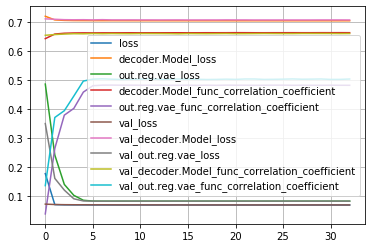

In [83]:
print('#samples/epoch = ', df_trial_train[~mask].shape[0]/my_batch_size, '\n')


earlystopping_VAE = kr.callbacks.EarlyStopping(patience=10, restore_best_weights=True)                   
tensorboard_VAE = kr.callbacks.TensorBoard(ruh_run_logdir)
checkpoint_VAE = kr.callbacks.ModelCheckpoint('saved_models/ruh_best_VAE.hd5', save_best_only=True)




myhistory = model_vae.fit(x = df_trial_train[~mask]
                          , y = {'decoder.Model':df_trial_train[~mask], 'out.reg.vae':xyz_coor_trial_train[~mask]}
                          , validation_data=({'input.vae':df_trial_train[mask]}
                                          ,{'decoder.Model':df_trial_train[mask], 'out.reg.vae':xyz_coor_trial_train[mask]}
                                          )
                          , epochs=my_nepochs
                          , callbacks=[earlystopping_VAE
                                       ,tensorboard_VAE
                                       ,checkpoint_VAE
                                       ]
                          , batch_size=my_batch_size
                       )



pd.DataFrame(myhistory.history).plot()
plt.grid(True)


mse_test_evalmethod_VAE = model_vae.evaluate( x = {'input.layer':df_trial_test}
                                             ,y = {'decoder.Model':df_trial_test , 'out.reg.vae':xyz_coor_trial_test}
                                            )




print()
print( 'my_batch_size = ', my_batch_size)
print( 'my_lr = ', my_lr)
print( 'my_ngenes_train = ', my_ngenes_train)
print( 'my_ncube_train = ', my_ncube_train)
print()

print('MSE test for VAE (.evaluate() method) =',mse_test_evalmethod_VAE)





<a id='custom_vae'></a>


## Custom VAE reg 
[Link to: **### create trial version (=subset) of the SPATIAL XP for the ease of use**](#create_trial_version)


In [8]:
len(gene_vs_goterm.columns)
gene_vs_goterm.shape
gvgo_trial == gene_vs_goterm

,MOLECULAR_FUNCTION,CELLULAR_COMPONENT,BIOLOGICAL_PROCESS,CENTROSOME,CYTOSOL,CENTRIOLAR_SATELLITE,PROTEIN_LOCALIZATION_TO_CENTROSOME,MEMBRANE,INTEGRAL_COMPONENT_OF_MEMBRANE,GLOBOSIDE_BIOSYNTHETIC_PROCESS,...,CLOACAL_SEPTATION,GLOMERULAR_VISCERAL_EPITHELIAL_CELL_DEVELOPMENT,GLOMERULUS_VASCULATURE_DEVELOPMENT,METANEPHRIC_NEPHRON_TUBULE_MORPHOGENESIS,OPTIC_PLACODE_FORMATION_INVOLVED_IN_CAMERA-TYPE_EYE_FORMATION,METANEPHRIC_S-SHAPED_BODY_MORPHOGENESIS,SCLEROTOME_DEVELOPMENT,URETER_UROTHELIUM_DEVELOPMENT,LIMBIC_SYSTEM_DEVELOPMENT,ENDOPLASMIC_RETICULUM_QUALITY_CONTROL_COMPARTMENT
0610010F05Rik,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1110008P14Rik,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1700037H04Rik,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1700086L19Rik,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2900026A02Rik,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zmynd11,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Znrf1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Zscan22,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Zswim6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "modelVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input.vae (InputLayer)          [(None, 3814)]       0                                            
_______________________________________________________________

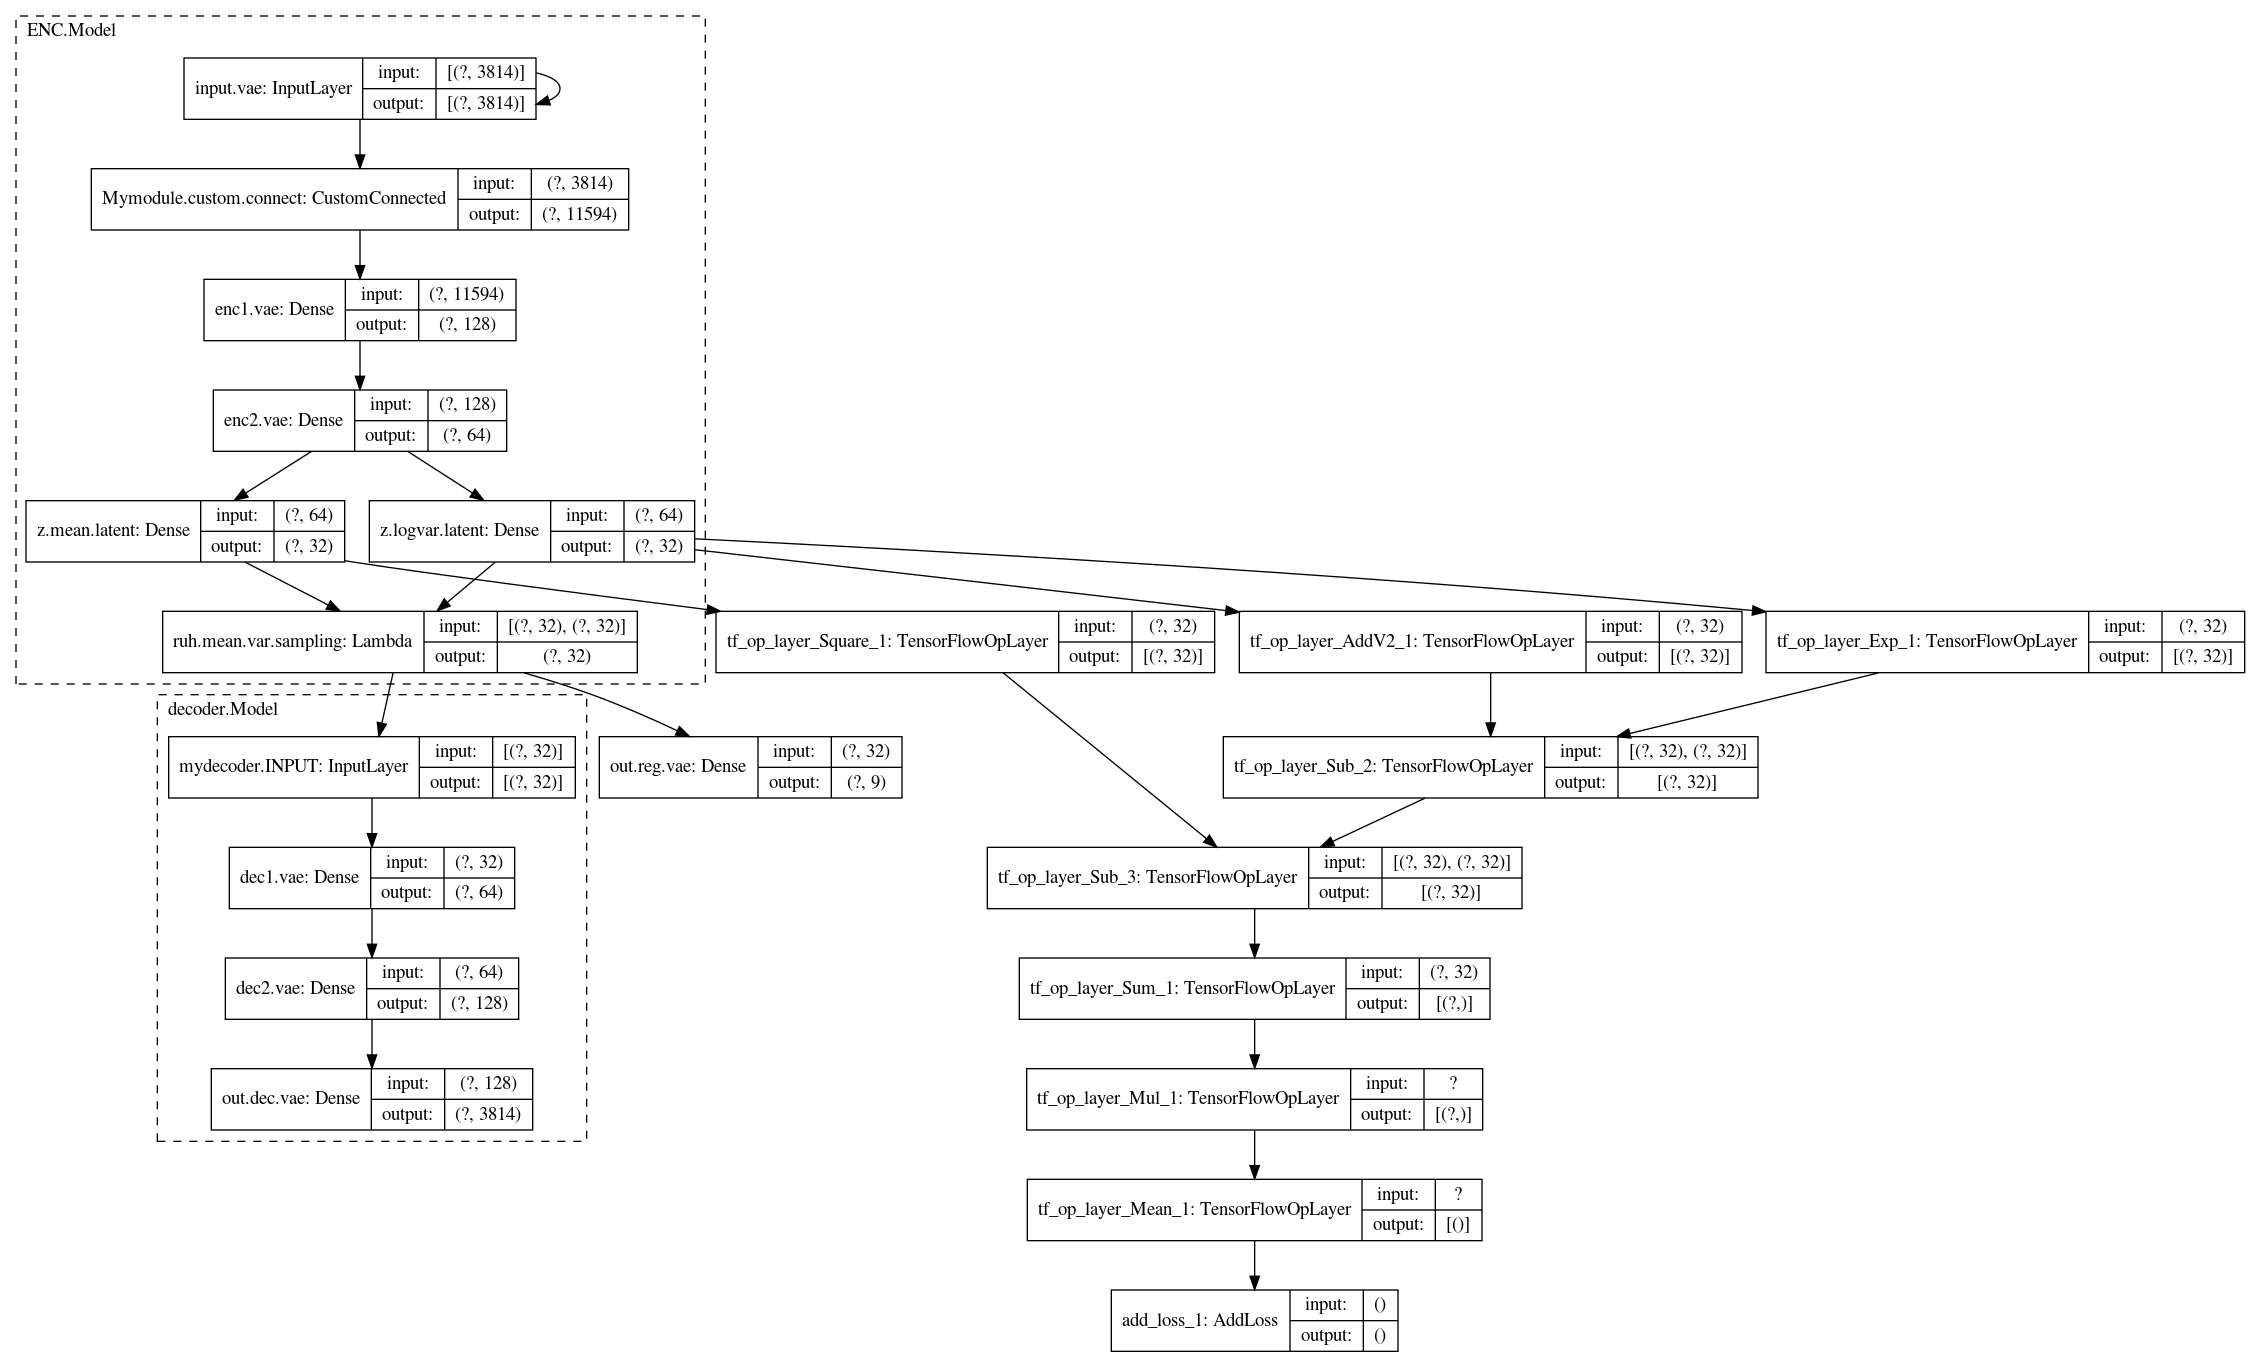

In [12]:
 ### CUSTOM VAE
    

    
    
import matplotlib.pyplot as plt


## corr coeff:
from tensorflow.keras import backend as K
import scipy as sp
def func_correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt( tf.multiply(  K.sum(K.square(xm)), K.sum(K.square(ym))  ) )
    r = r_num / r_den
#     r = sp.stats.pearsonr(x.numpy(),y.numpy())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

### end corr coeff



## create root log dir for TensorBoard
import os
root_logdir = os.path.join(os.curdir, 'ruh_rootdir_logs_vae')

def get_run_logdir(subdir_name):
    import time
    run_id = time.strftime(subdir_name+'_%Y_%m_%d.%H:%M:%S')
    return os.path.join(root_logdir, run_id)

ruh_run_logdir = get_run_logdir(subdir_name = 'CustomVAE')


my_batch_size = 128
my_lr = .001
my_ngenes_train = df_trial_train.shape[1]
my_ncube_train = df_trial_train[~mask].shape[0]
nunit_output = xyz_coor_trial_train.shape[1]

my_nepochs = 100

n_neurons = df_trial_train.shape[1] # #not iterable
n_neurons_latent = 32
n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)




def ruh_sampling(args): ##chollet
    zmean, zlogvar = args
    myshape = ( K.shape(zmean)[0] , n_neurons_latent ) 
    epsilon = K.random_normal(  shape = myshape #A tuple of integers, the shape of tensor to create. 
                              , mean=0. #default
                              , stddev=1. #default
                             )
    return zmean + K.exp(zlogvar/2)*epsilon

class class_ruh_sampling(kr.layers.Layer): ##handson
    def call(self, my_sampling_inputs):
        zmean, zlogvar = my_sampling_inputs
        return zmean + K.random_normal(tf.shape(zlogvar))  * K.exp(zlogvar/2) 
        



    
class CustomConnected(kr.layers.Dense):
    def __init__(self,units,connections,**kwargs):
        #this is matrix A
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self,inputs):
        output = K.dot(inputs, self.kernel * self.connections)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def get_weights(self):
        weights = super(CustomConnected,self).get_weights()
        return [weights[0] * self.connections, weights[1]]


## input layer»
my_Input_layer = kr.layers.Input(shape=(n_neurons,), name = 'input.vae') #shape=df_trial_train.shape[1:])


### for fun layer!!:
some_fun = kr.layers.Input(10, name = 'funnn')

### custom connect
module_shape = len(gvgo_trial.columns)
modules = CustomConnected(units = module_shape
                          , connections = gvgo_trial
                          , kernel_initializer='glorot_uniform'
                          , name = 'Mymodule.custom.connect'
                          , activation = 'relu'
                         )(my_Input_layer)




## encoder:
encoder_layer = kr.layers.Dense(n_neurons1, activation = 'relu', name = 'enc1.vae')(modules)
encoder_layer = kr.layers.Dense(n_neurons2, activation = 'relu', name = 'enc2.vae')(encoder_layer)


###  mean & var layers for vae
z_mean_vae =    kr.layers.Dense(n_neurons_latent, activation = 'relu' , name = 'z.mean.latent')(encoder_layer)
z_log_var_vae = kr.layers.Dense(n_neurons_latent, activation = 'relu' , name = 'z.logvar.latent')(encoder_layer)


        
        
## latent space = sampling
sampling_layer = kr.layers.Lambda(ruh_sampling, name = 'ruh.mean.var.sampling')([z_mean_vae , z_log_var_vae]) #chollet
# sampling_layer = class_ruh_sampling(name = 'ruh.mean.var.sampling.class' )([z_mean_vae , z_log_var_vae]) # handson

model_ENCODER = kr.models.Model(inputs = [my_Input_layer]
                                , outputs = [z_mean_vae, z_log_var_vae , sampling_layer] ## three outputs in case you want to inspect the values of z_mean_vae &  z_log_var_vae 
                                , name = 'ENC.Model'
                               )

## decoder:
decoder_input = kr.layers.Input(shape = [n_neurons_latent], name = 'mydecoder.INPUT' )

decoder_layer = kr.layers.Dense(n_neurons2 , activation = 'relu', name = 'dec1.vae')(decoder_input) 
# x          = keras.layers.Dense(100, activation="selu", name = '1Dec.ruh.dense')(decoder_inputs)

decoder_layer = kr.layers.Dense(n_neurons1 , activation = 'relu', name = 'dec2.vae')(decoder_layer)
decoder_layer = kr.layers.Dense(n_neurons  , activation = 'relu', name = 'out.dec.vae')(decoder_layer)

model_decoder = kr.models.Model(inputs = [decoder_input]
                                , outputs = [decoder_layer]
                                , name = 'decoder.Model'
                               )

## regression:
reg_layer = kr.layers.Dense(nunit_output, activation = 'relu', name = 'out.reg.vae')(sampling_layer)## sigmoid if b/w [0,1]




### #handson:
_,_,feed_latent_to_decoder = model_ENCODER(my_Input_layer) #ignore the first two outputs of model_ENCODER
reconstructions = model_decoder(feed_latent_to_decoder)
model_custom_vae = kr.models.Model(inputs= my_Input_layer , outputs = [reconstructions, reg_layer], name = 'modelVAE')


# # my_outputs = kr.layers.Dense(n_neurons)(decoder_layer)

# ## stacked ae
# # model_custom_vae = kr.models.Model(inputs = [my_Input_layer], outputs = )
# model_custom_vae = kr.models.Model(my_Input_layer, [decoder_layer, reg_layer]) #kr.models.Model(encoder_layer, my_outputs)
model_custom_vae.summary()


## optimization + loss + metrics
myoptimizer_sgd = kr.optimizers.SGD(lr = my_lr, momentum=.9, nesterov=True) #, momentum=.01)
myoptimizer_adam = kr.optimizers.Adam(lr = my_lr, beta_1=.9, beta_2=.999)


## KL divergence b/w target distribution and actual distribution of the latent space
latent_loss = -.5 * K.sum( 1 + z_log_var_vae - K.exp(z_log_var_vae) - K.square(z_mean_vae)
                          , axis=-1 
                         )
model_custom_vae.add_loss(K.mean(latent_loss))                         


model_custom_vae.compile(loss ={'decoder.Model': 'mse' , 'out.reg.vae':'mse'}
                         , loss_weights = {'out.reg.vae': .001, 'decoder.Model':.1 }
                         , optimizer = myoptimizer_adam
                         , metrics= {'out.reg.vae':[func_correlation_coefficient], 'decoder.Model':[func_correlation_coefficient]}
                         )


model_custom_vae_fig = tf.keras.utils.plot_model(model=model_custom_vae
                             ,to_file='model_custom_vae.png'
                             ,show_shapes=True
#                              ,show_dtype = True
                             , expand_nested=True
                             )
model_custom_vae_fig

In [13]:
print('#samples/epoch = ', df_trial_train[~mask].shape[0]/my_batch_size, '\n')


earlystopping_VAE = kr.callbacks.EarlyStopping(patience=10, restore_best_weights=True)                   
tensorboard_VAE = kr.callbacks.TensorBoard(ruh_run_logdir)
checkpoint_VAE = kr.callbacks.ModelCheckpoint('saved_models/ruh_best_customVAE.hd5', save_best_only=True)




myhistory = model_custom_vae.fit(x = df_trial_train[~mask]
                          , y = {'decoder.Model':df_trial_train[~mask], 'out.reg.vae':xyz_coor_trial_train[~mask]}
                          , validation_data=({'input.vae':df_trial_train[mask]}
                                          ,{'decoder.Model':df_trial_train[mask], 'out.reg.vae':xyz_coor_trial_train[mask]}
                                          )
                          , epochs=my_nepochs
                          , callbacks=[earlystopping_VAE
                                       ,tensorboard_VAE
                                       ,checkpoint_VAE
                                       ]
                          , batch_size=my_batch_size
                       )



pd.DataFrame(myhistory.history).plot()
plt.grid(True)


mse_test_evalmethod_VAE = model_custom_vae.evaluate( x = {'input.layer':df_trial_test}
                                             ,y = {'decoder.Model':df_trial_test , 'out.reg.vae':xyz_coor_trial_test}
                                            )




print()
print( 'my_batch_size = ', my_batch_size)
print( 'my_lr = ', my_lr)
print( 'my_ngenes_train = ', my_ngenes_train)
print( 'my_ncube_train = ', my_ncube_train)
print()

print('MSE test for VAE (.evaluate() method) =',mse_test_evalmethod_VAE)





#samples/epoch =  425.2265625 

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to t

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: saved_models/ruh_best_customVAE.hd5/assets
426/426 [==============================] - 132s 310ms/step - loss: 0.0706 - decoder.Model_loss: 0.7053 - out.reg.vae_loss: 0.0877 - decoder.Model_func_correlation_coefficient: 0.6608 - out.reg.vae_func_correlation_coefficient: 0.4698 - val_loss: 0.0708 - val_decoder.Model_loss: 0.7076 - val_out.reg.vae_loss: 0.0838 - val_decoder.Model_func_correlation_coefficient: 0.6585 - val_out.reg.vae_func_correlation_coefficient: 0.5026
Epoch 4/100
426/426 [==============================] - ETA: 0s - loss: 0.0706 - decoder.Model_loss: 0.7047 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.

426/426 [==============================] - 110s 258ms/step - loss: 0.0705 - decoder.Model_loss: 0.7040 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6627 - out.reg.vae_func_correlation_coefficient: 0.4823 - val_loss: 0.0708 - val_decoder.Model_loss: 0.7069 - val_out.reg.vae_loss: 0.0837 - val_decoder.Model_func_correlation_coefficient: 0.6595 - val_out.reg.vae_func_correlation_coefficient: 0.5038
Epoch 23/100
426/426 [==============================] - ETA: 0s - loss: 0.0705 - decoder.Model_loss: 0.7041 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6628 - out.reg.vae_func_correlation_coefficient: 0.4829WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f26abced200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' ob

Epoch 33/100
426/426 [==============================] - 110s 259ms/step - loss: 0.0705 - decoder.Model_loss: 0.7040 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6629 - out.reg.vae_func_correlation_coefficient: 0.4825 - val_loss: 0.0708 - val_decoder.Model_loss: 0.7067 - val_out.reg.vae_loss: 0.0837 - val_decoder.Model_func_correlation_coefficient: 0.6600 - val_out.reg.vae_func_correlation_coefficient: 0.5042
Epoch 34/100
426/426 [==============================] - 109s 257ms/step - loss: 0.0705 - decoder.Model_loss: 0.7040 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6630 - out.reg.vae_func_correlation_coefficient: 0.4824 - val_loss: 0.0708 - val_decoder.Model_loss: 0.7069 - val_out.reg.vae_loss: 0.0838 - val_decoder.Model_func_correlation_coefficient: 0.6595 - val_out.reg.vae_func_correlation_coefficient: 0.5039
Epoch 35/100
426/426 [==============================] - ETA: 0s - loss: 0.0705 - decoder.Model_loss: 0.7040 - out.re

Epoch 44/100
426/426 [==============================] - 113s 266ms/step - loss: 0.0705 - decoder.Model_loss: 0.7039 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6630 - out.reg.vae_func_correlation_coefficient: 0.4822 - val_loss: 0.0708 - val_decoder.Model_loss: 0.7067 - val_out.reg.vae_loss: 0.0840 - val_decoder.Model_func_correlation_coefficient: 0.6601 - val_out.reg.vae_func_correlation_coefficient: 0.5019
Epoch 45/100
426/426 [==============================] - 113s 265ms/step - loss: 0.0705 - decoder.Model_loss: 0.7039 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6630 - out.reg.vae_func_correlation_coefficient: 0.4821 - val_loss: 0.0708 - val_decoder.Model_loss: 0.7067 - val_out.reg.vae_loss: 0.0838 - val_decoder.Model_func_correlation_coefficient: 0.6600 - val_out.reg.vae_func_correlation_coefficient: 0.5036
Epoch 46/100
426/426 [==============================] - 113s 266ms/step - loss: 0.0705 - decoder.Model_loss: 0.7039 

Epoch 60/100
426/426 [==============================] - 111s 261ms/step - loss: 0.0705 - decoder.Model_loss: 0.7039 - out.reg.vae_loss: 0.0839 - decoder.Model_func_correlation_coefficient: 0.6630 - out.reg.vae_func_correlation_coefficient: 0.4819 - val_loss: 0.0708 - val_decoder.Model_loss: 0.7067 - val_out.reg.vae_loss: 0.0839 - val_decoder.Model_func_correlation_coefficient: 0.6600 - val_out.reg.vae_func_correlation_coefficient: 0.5017
Epoch 61/100
426/426 [==============================] - 135s 316ms/step - loss: 0.0705 - decoder.Model_loss: 0.7039 - out.reg.vae_loss: 0.0838 - decoder.Model_func_correlation_coefficient: 0.6631 - out.reg.vae_func_correlation_coefficient: 0.4821 - val_loss: 0.0707 - val_decoder.Model_loss: 0.7067 - val_out.reg.vae_loss: 0.0838 - val_decoder.Model_func_correlation_coefficient: 0.6602 - val_out.reg.vae_func_correlation_coefficient: 0.5034
Epoch 62/100
426/426 [==============================] - 134s 315ms/step - loss: 0.0705 - decoder.Model_loss: 0.7039 

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [136]:
 ### BUILD CUSTOM VAE through fuction
    
    
import matplotlib.pyplot as plt


## corr coeff:
from tensorflow.keras import backend as K
import scipy as sp
def func_correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt( tf.multiply(  K.sum(K.square(xm)), K.sum(K.square(ym))  ) )
    r = r_num / r_den
#     r = sp.stats.pearsonr(x.numpy(),y.numpy())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

### end corr coeff



## create root log dir for TensorBoard
import os
root_logdir = os.path.join(os.curdir, 'ruh_rootdir_logs_vae')

def get_run_logdir(subdir_name):
    import time
    run_id = time.strftime(subdir_name+'_%Y_%m_%d.%H:%M:%S')
    return os.path.join(root_logdir, run_id)

ruh_run_logdir = get_run_logdir(subdir_name = 'CustomVAE')


# my_batch_size = 128
# my_lr = .001
# my_ngenes_train = input_x.shape[1]
# my_ncube_train = input_x[~input_mask].shape[0]
# nunit_output = input_xyz_coor.shape[1]

# input_my_nepochs = 2

# n_neurons = input_x.shape[1] # #not iterable

# del n_neurons_latent
# n_neurons_latent = 32
# n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
# n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)



def ruh_sampling(args,internal_n_neurons_latent): #(zmean, zlogvar,internal_n_neurons_latent): #(args,internal_n_neurons_latent): ##chollet
    zmean, zlogvar = args#,internal_n_neurons_latent = args
#     internal_n_neurons_latent = n_neurons_latent
    
    
    myshape = ( K.shape(zmean)[0] , internal_n_neurons_latent ) 
    epsilon = K.random_normal(  shape = myshape #A tuple of integers, the shape of tensor to create. 
                              , mean=0. #default
                              , stddev=1. #default
                             )
    print('ruh_sampling says: types of zmean, zlogvar,internal_n_neurons_latent',type(zmean), type(zlogvar) ,type(internal_n_neurons_latent))
    return zmean + K.exp(zlogvar/2)*epsilon

class class_ruh_sampling(kr.layers.Layer): ##handson
    def call(self, my_sampling_inputs):
        zmean, zlogvar = my_sampling_inputs
        return zmean + K.random_normal(tf.shape(zlogvar))  * K.exp(zlogvar/2) 
        



    
class CustomConnected(kr.layers.Dense):
    def __init__(self,units,connections,**kwargs):
        #this is matrix A
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self,inputs):
        output = K.dot(inputs, self.kernel * self.connections)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def get_weights(self):
        weights = super(CustomConnected,self).get_weights()
        return [weights[0] * self.connections, weights[1]]
    
earlystopping_VAE = kr.callbacks.EarlyStopping(patience=10, restore_best_weights=True)                   
tensorboard_VAE = kr.callbacks.TensorBoard(ruh_run_logdir)
checkpoint_VAE = kr.callbacks.ModelCheckpoint('saved_models/ruh_best_customVAE.hd5', save_best_only=True)

    

def ruh_func_customvae_maker(input_x, input_xyz_coor, input_mask
                             , connection_df
                             , input_my_nepochs
                             , input_params
                            ):
 
    n_neurons = input_x.shape[1]
    n_neurons_latent = input_params['latent_neuron']
    n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
    n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)
    nunit_output = input_xyz_coor.shape[1]
    my_lr = .001 #input_params['input_lr']
    my_batch_size = input_params['input_batch_size']
    print('#samples/epoch = ', round(input_x[~input_mask].shape[0]/my_batch_size), '\n')

    ## input layer»
    my_Input_layer = kr.layers.Input(shape=(n_neurons,), name = 'input.vae') #shape=input_x.shape[1:])


    ### for fun layer!!:
    some_fun = kr.layers.Input(10, name = 'funnn')

    ### custom connect
    module_shape = len(connection_df.columns)
    modules = CustomConnected(units = module_shape
                              , connections = connection_df
                              , kernel_initializer='glorot_uniform'
                              , name = 'Mymodule.custom.connect'
                              , activation = 'relu'
                             )(my_Input_layer)




    ## encoder:
    encoder_layer = kr.layers.Dense(n_neurons1, activation = 'relu', name = 'enc1.vae')(modules)
    encoder_layer = kr.layers.Dense(n_neurons2, activation = 'relu', name = 'enc2.vae')(encoder_layer)


    ###  mean & var layers for vae
    z_mean_vae =    kr.layers.Dense(n_neurons_latent, activation = 'relu' , name = 'z.mean.latent')(encoder_layer)
    z_log_var_vae = kr.layers.Dense(n_neurons_latent, activation = 'relu' , name = 'z.logvar.latent')(encoder_layer)




    ## latent space = sampling
    sampling_layer = kr.layers.Lambda(ruh_sampling, name = 'ruh.mean.var.sampling', arguments = {'internal_n_neurons_latent':n_neurons_latent})([z_mean_vae , z_log_var_vae]) #([z_mean_vae , z_log_var_vae],n_neurons_latent) #chollet
    # sampling_layer = class_ruh_sampling(name = 'ruh.mean.var.sampling.class' )([z_mean_vae , z_log_var_vae]) # handson

    model_ENCODER = kr.models.Model(inputs = [my_Input_layer]
                                    , outputs = [z_mean_vae, z_log_var_vae , sampling_layer] ## three outputs in case you want to inspect the values of z_mean_vae &  z_log_var_vae 
                                    , name = 'ENC.Model'
                                   )

    ## decoder:
    decoder_input = kr.layers.Input(shape = [n_neurons_latent], name = 'mydecoder.INPUT' )

    decoder_layer = kr.layers.Dense(n_neurons2 , activation = 'relu', name = 'dec1.vae')(decoder_input) 
    # x          = keras.layers.Dense(100, activation="selu", name = '1Dec.ruh.dense')(decoder_inputs)

    decoder_layer = kr.layers.Dense(n_neurons1 , activation = 'relu', name = 'dec2.vae')(decoder_layer)
    decoder_layer = kr.layers.Dense(n_neurons  , activation = 'relu', name = 'out.dec.vae')(decoder_layer)

    model_decoder = kr.models.Model(inputs = [decoder_input]
                                    , outputs = [decoder_layer]
                                    , name = 'decoder.Model'
                                   )

    ## regression:
    reg_layer = kr.layers.Dense(nunit_output, activation = 'relu', name = 'out.reg.vae')(sampling_layer)## sigmoid if b/w [0,1]




    ### #handson:
    _,_,feed_latent_to_decoder = model_ENCODER(my_Input_layer) #ignore the first two outputs of model_ENCODER
    reconstructions = model_decoder(feed_latent_to_decoder)
    my_model_custom_vae = kr.models.Model(inputs= my_Input_layer , outputs = [reconstructions, reg_layer], name = 'modelVAE')


    # # my_outputs = kr.layers.Dense(n_neurons)(decoder_layer)

    # ## stacked ae
    # # my_model_custom_vae = kr.models.Model(inputs = [my_Input_layer], outputs = )
    # my_model_custom_vae = kr.models.Model(my_Input_layer, [decoder_layer, reg_layer]) #kr.models.Model(encoder_layer, my_outputs)
    my_model_custom_vae.summary()


    ## optimization + loss + metrics
    myoptimizer_sgd = kr.optimizers.SGD(lr = my_lr, momentum=.9, nesterov=True) #, momentum=.01)
    myoptimizer_adam = kr.optimizers.Adam(lr = my_lr, beta_1=.9, beta_2=.999)


    ## KL divergence b/w target distribution and actual distribution of the latent space
    latent_loss = -.5 * K.sum( 1 + z_log_var_vae - K.exp(z_log_var_vae) - K.square(z_mean_vae)
                              , axis=-1 
                             )
    my_model_custom_vae.add_loss(K.mean(latent_loss))                         


    my_model_custom_vae.compile(loss ={'decoder.Model': 'mse' , 'out.reg.vae':'mse'}
                              , loss_weights = {'out.reg.vae': .001, 'decoder.Model':.1 }
                              , optimizer = myoptimizer_adam, metrics= {'out.reg.vae':[func_correlation_coefficient], 'decoder.Model':[func_correlation_coefficient]}
                                )


    
    
    my_hist = my_model_custom_vae.fit(x = input_x[~input_mask]
                          , y = {'decoder.Model':input_x[~input_mask], 'out.reg.vae':input_xyz_coor[~input_mask]}
                          , validation_data=({'input.vae':input_x[input_mask]}
                                          ,{'decoder.Model':input_x[input_mask], 'out.reg.vae':input_xyz_coor[input_mask]}
                                          )
                          , epochs=input_my_nepochs
                          , callbacks=[earlystopping_VAE
                                       ,tensorboard_VAE
                                       ,checkpoint_VAE
                                       ]
                          , batch_size=my_batch_size
                       )

    return my_hist, my_model_custom_vae




In [ ]:
param = {'latent_neuron': 32 , 'input_lr': .001 , 'input_batch_size': 128 } ## works normally w/out talos 

returned_hist, returned_model = ruh_func_customvae_maker(input_x=df_trial_train
                         , input_xyz_coor = xyz_coor_trial_train
                         , input_mask = mask
                         , connection_df = gvgo_trial
                             , input_my_nepochs = 1
                             , input_params = param
                            )

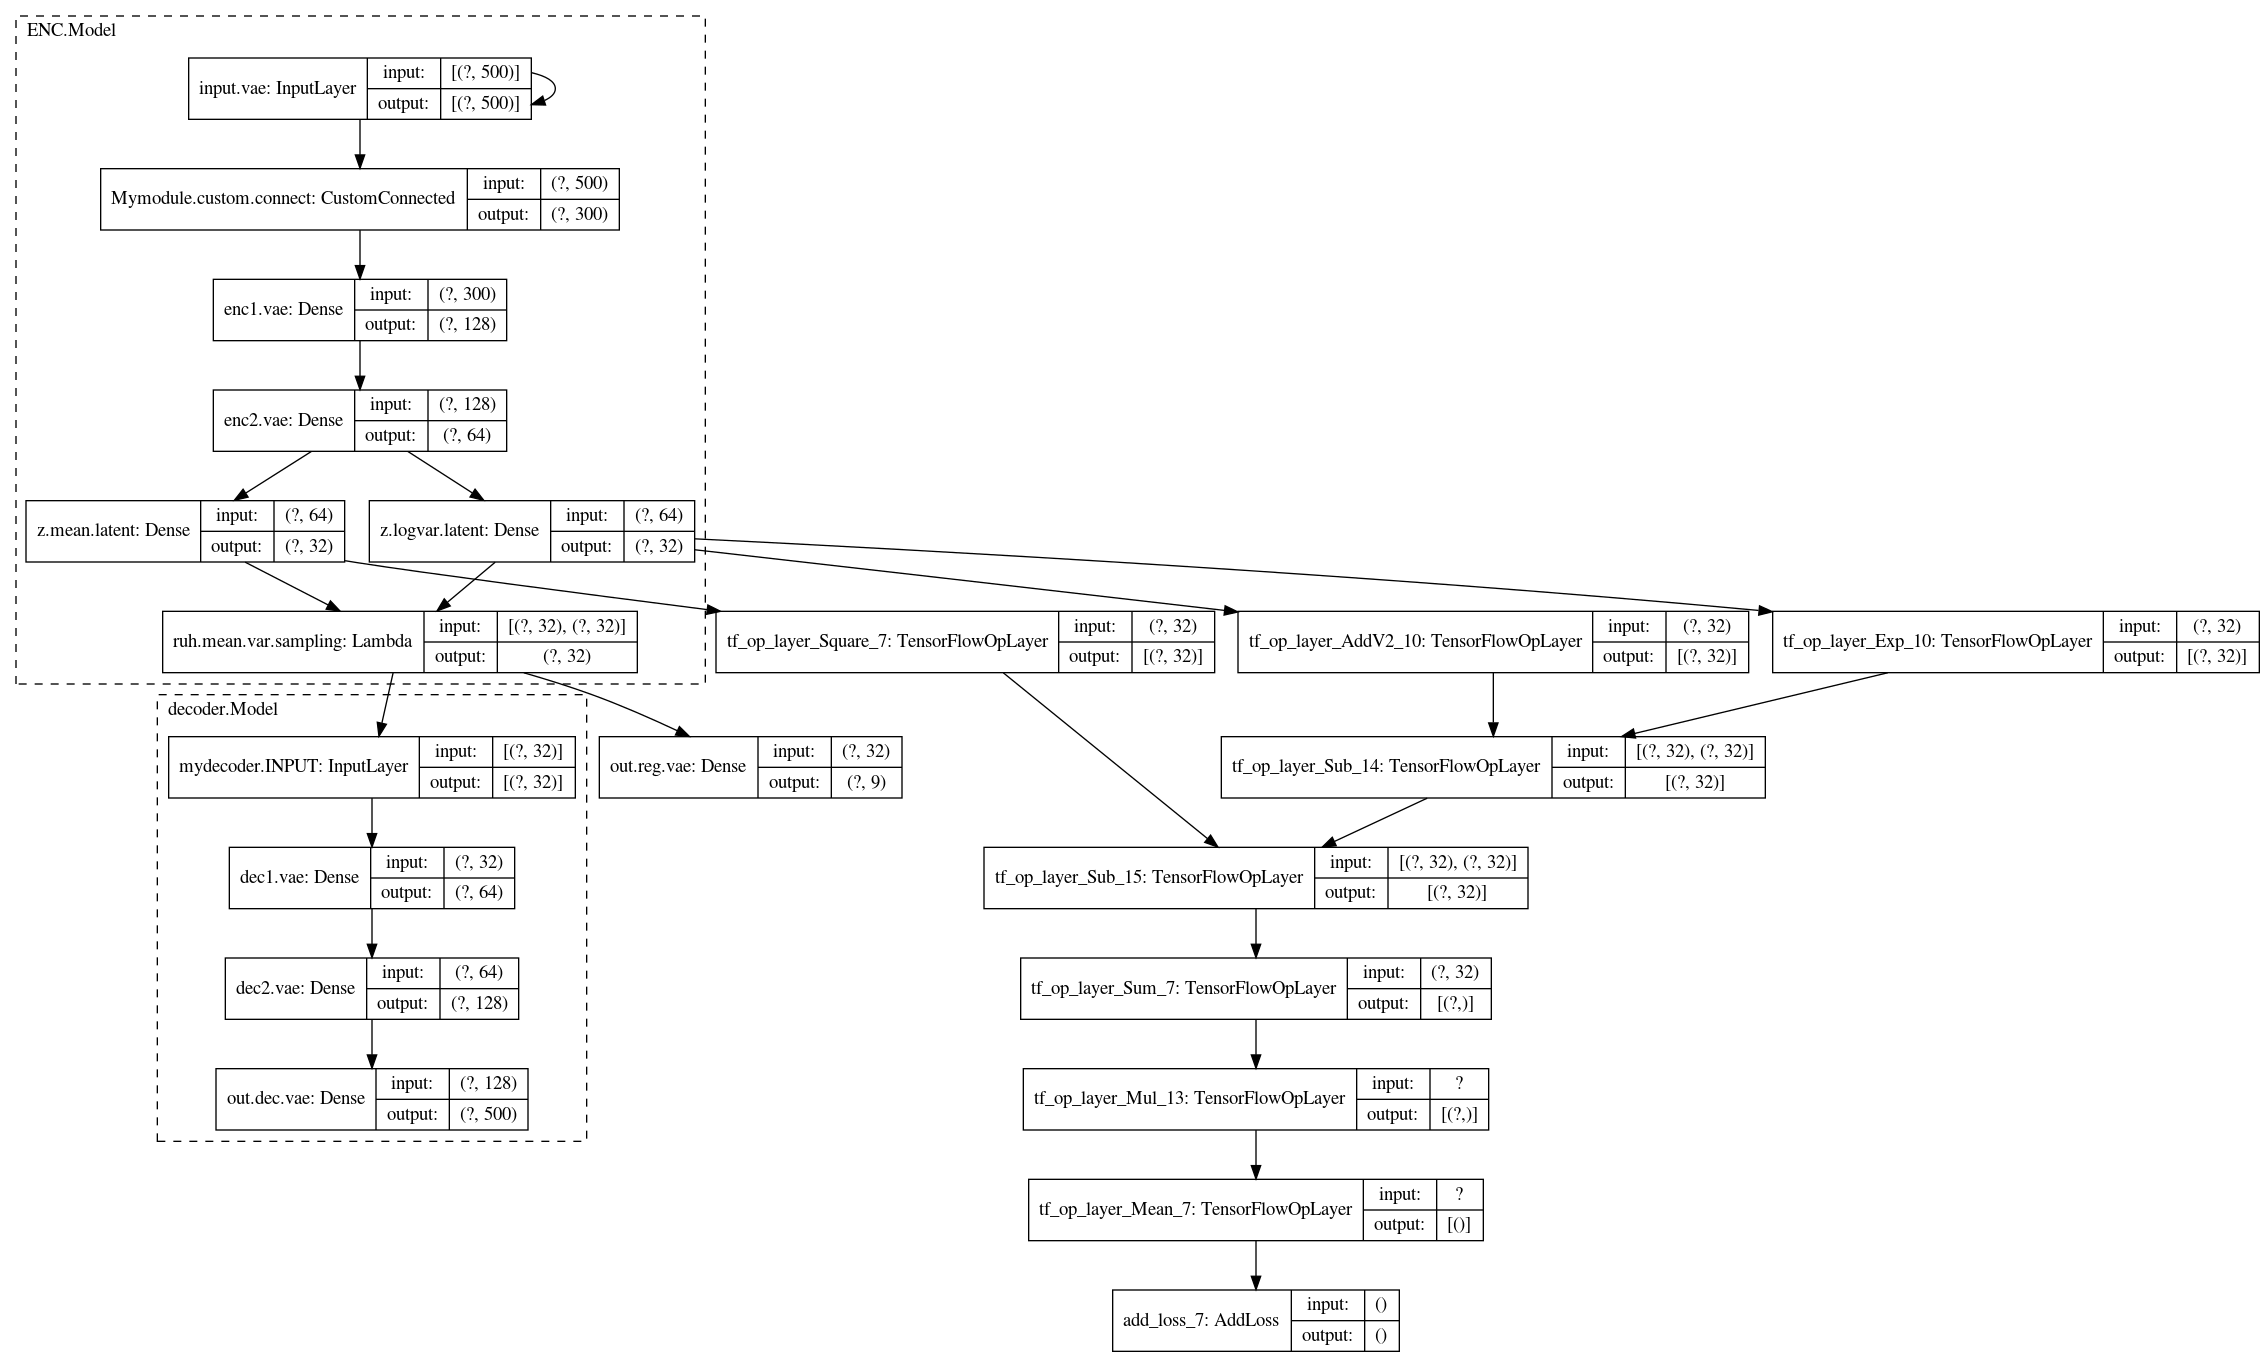

In [135]:
my_model_custom_vae_fig = tf.keras.utils.plot_model(model=returned_model
                             ,to_file='my_model_custom_vae_talos.png'
                             ,show_shapes=True
#                              ,show_dtype = True
                             , expand_nested=True
                             )
my_model_custom_vae_fig






<a id='talos_custom_vae'></a>

## Hyperparameter tuning of custom VAE w/ Talos
To get started with your first experiment is easy. You need to have three things:

    a hyperparameter dictionary
    a working Keras model
    a Talos experiment

STEP 1 >> In a regular Python dictionary, you declare the hyperparameters and the boundaries you want to include in the experiment.

STEP 2 >> In order to prepare a Keras model for a Talos experiment, you simply replace parameters you want to include in the scan, with references to the parameter dictionary.

STEP 3 >> To start the experiment, you input the parameter dictionary and the Keras model into Talos with the option for Grid, Random, or Probabilistic optimization strategy.


---


##### Configuring the Keras Model for Talos

In order to prepare a Keras model for a Talos experiment, we need to do four things:

    add input parameters to the function
    replace the hyperparameter inputs with references to params dictionary
    make sure model.fit() stores the history object
    modify the output of the model

These steps are always the same.

[Link to: **### create trial version (=subset) of the SPATIAL XP for the ease of use**](#create_trial_version)


In [168]:
 ### CUSTOM VAE function for talos
    
    
import matplotlib.pyplot as plt


## corr coeff:
from tensorflow.keras import backend as K
import scipy as sp
def func_correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt( tf.multiply(  K.sum(K.square(xm)), K.sum(K.square(ym))  ) )
    r = r_num / r_den
#     r = sp.stats.pearsonr(x.numpy(),y.numpy())
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

### end corr coeff



## create root log dir for TensorBoard
import os
root_logdir = os.path.join(os.curdir, 'ruh_rootdir_logs_vae_talos')

def get_run_logdir(subdir_name):
    import time
    run_id = time.strftime(subdir_name+'_%Y_%m_%d.%H:%M:%S')
    return os.path.join(root_logdir, run_id)

ruh_run_logdir = get_run_logdir(subdir_name = 'CustomVAE')


# my_batch_size = 128
# my_lr = .001
# my_ngenes_train = x_train.shape[1]
# my_ncube_train = x_train[~input_mask].shape[0]
# nunit_output = input_xyz_coor.shape[1]

# input_my_nepochs = 2

# n_neurons = x_train.shape[1] # #not iterable

# del n_neurons_latent
# n_neurons_latent = 32
# n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
# n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)



def ruh_sampling(args,internal_n_neurons_latent): #(zmean, zlogvar,internal_n_neurons_latent): #(args,internal_n_neurons_latent): ##chollet
    zmean, zlogvar = args#,internal_n_neurons_latent = args
#     internal_n_neurons_latent = n_neurons_latent
    
    
    myshape = ( K.shape(zmean)[0] , internal_n_neurons_latent ) 
    epsilon = K.random_normal(  shape = myshape #A tuple of integers, the shape of tensor to create. 
                              , mean=0. #default
                              , stddev=1. #default
                             )
   # print('ruh_sampling says: types of zmean, zlogvar,internal_n_neurons_latent',type(zmean), type(zlogvar) ,type(internal_n_neurons_latent))
    return zmean + K.exp(zlogvar/2)*epsilon

class class_ruh_sampling(kr.layers.Layer): ##handson
    def call(self, my_sampling_inputs):
        zmean, zlogvar = my_sampling_inputs
        return zmean + K.random_normal(tf.shape(zlogvar))  * K.exp(zlogvar/2) 
        



    
class CustomConnected(kr.layers.Dense):
    def __init__(self,units,connections,**kwargs):
        #this is matrix A
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self,inputs):
        output = K.dot(inputs, self.kernel * self.connections)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def get_weights(self):
        weights = super(CustomConnected,self).get_weights()
        return [weights[0] * self.connections, weights[1]]
    
earlystopping_VAE = kr.callbacks.EarlyStopping(patience=10, restore_best_weights=True)                   
tensorboard_VAE = kr.callbacks.TensorBoard(ruh_run_logdir)
# checkpoint_VAE = kr.callbacks.ModelCheckpoint('saved_models_talos/ruh_best_customVAE.hd5', save_best_only=True)
checkpoint_VAE = kr.callbacks.ModelCheckpoint('saved_models_talos_jan26_2021/ruh_best_customVAE.hd5', save_best_only=True)



# x_train = df_trial_train[~mask]
# y_train = {'decoder.Model':df_trial_train[~mask], 'out.reg.vae':xyz_coor_trial_train[~mask]}
# x_val = df_trial_train[mask]
# y_val = {'decoder.Model':df_trial_train[mask], 'out.reg.vae':xyz_coor_trial_train[mask]}


def ruh_func_customvae_maker(x_train, y_train, x_val, y_val, input_params):
                             
                             
                             
#                              input_xyz_coor, input_mask
#                              , 
#                              , input_my_nepochs
#                              , input_params
#                             ):
 
    
    n_neurons = x_train.shape[1]
    n_neurons_latent = input_params['latent_neuron']
    
    n_neurons1 = n_neurons_latent * 4 #int(n_neurons/2)
    n_neurons2 = n_neurons_latent * 2 #int(n_neurons/16)
    nunit_output = y_train['out.reg.vae'].shape[1] #input_xyz_coor.shape[1]
    
    my_lr = input_params['input_lr']
    my_nepochs = 3 #5 #10
    my_batch_size = input_params['input_batch_size']
    print('#samples/epoch = ', round(x_train.shape[0]/my_batch_size), '\n')

    ## input layer»
    my_Input_layer = kr.layers.Input(shape=(n_neurons,), name = 'input.vae') #shape=x_train.shape[1:])


    ### for fun layer!!:
    some_fun = kr.layers.Input(10, name = 'funnn')

    ### custom connect
    module_shape = len(gvgo_trial.columns)
    modules = CustomConnected(units = module_shape
                              , connections = gvgo_trial
                              , kernel_initializer='glorot_uniform'
                              , name = 'Mymodule.custom.connect'
                              , activation = input_params['ruh_activation'] #'relu'
                             )(my_Input_layer)




    ## encoder:
    encoder_layer = kr.layers.Dense(n_neurons1, activation = input_params['ruh_activation'], name = 'enc1.vae')(modules)
    encoder_layer = kr.layers.Dense(n_neurons2, activation = input_params['ruh_activation'], name = 'enc2.vae')(encoder_layer)


    ###  mean & var layers for vae
    z_mean_vae =    kr.layers.Dense(n_neurons_latent, activation = input_params['ruh_activation'] , name = 'z.mean.latent')(encoder_layer)
    z_log_var_vae = kr.layers.Dense(n_neurons_latent, activation = input_params['ruh_activation'] , name = 'z.logvar.latent')(encoder_layer)




    ## latent space = sampling
    sampling_layer = kr.layers.Lambda( ruh_sampling
                                      ,name = 'ruh.mean.var.sampling'
                                      ,arguments = {'internal_n_neurons_latent':n_neurons_latent}
                                     )([z_mean_vae , z_log_var_vae]) #([z_mean_vae , z_log_var_vae],n_neurons_latent) #chollet
    
    # sampling_layer = class_ruh_sampling(name = 'ruh.mean.var.sampling.class' )([z_mean_vae , z_log_var_vae]) # handson

    model_ENCODER = kr.models.Model(inputs = [my_Input_layer]
                                    , outputs = [z_mean_vae, z_log_var_vae , sampling_layer] ## three outputs in case you want to inspect the values of z_mean_vae &  z_log_var_vae 
                                    , name = 'ENC.Model'
                                   )

    ## decoder:
    decoder_input = kr.layers.Input(shape = [n_neurons_latent], name = 'mydecoder.INPUT' )

    decoder_layer = kr.layers.Dense(n_neurons2 , activation = input_params['ruh_activation'], name = 'dec1.vae')(decoder_input) 
    # x          = keras.layers.Dense(100, activation="selu", name = '1Dec.ruh.dense')(decoder_inputs)

    decoder_layer = kr.layers.Dense(n_neurons1 , activation = input_params['ruh_activation'], name = 'dec2.vae')(decoder_layer)
    decoder_layer = kr.layers.Dense(n_neurons  , activation = input_params['ruh_activation'], name = 'out.dec.vae')(decoder_layer)

    model_decoder = kr.models.Model(inputs = [decoder_input]
                                    , outputs = [decoder_layer]
                                    , name = 'decoder.Model'
                                   )

    ## regression:
    reg_layer = kr.layers.Dense(nunit_output, activation = input_params['ruh_activation'], name = 'out.reg.vae')(sampling_layer)## sigmoid if b/w [0,1]




    ### #handson:
    _,_,feed_latent_to_decoder = model_ENCODER(my_Input_layer) #ignore the first two outputs of model_ENCODER
    reconstructions = model_decoder(feed_latent_to_decoder)
    my_model_custom_vae = kr.models.Model(inputs= my_Input_layer , outputs = [reconstructions, reg_layer], name = 'modelVAE')


    # # my_outputs = kr.layers.Dense(n_neurons)(decoder_layer)

    # ## stacked ae
    # # my_model_custom_vae = kr.models.Model(inputs = [my_Input_layer], outputs = )
    # my_model_custom_vae = kr.models.Model(my_Input_layer, [decoder_layer, reg_layer]) #kr.models.Model(encoder_layer, my_outputs)
    my_model_custom_vae.summary()


    ## optimization + loss + metrics
    myoptimizer_sgd = kr.optimizers.SGD(lr = my_lr, momentum=.9, nesterov=True) #, momentum=.01)
    myoptimizer_adam = kr.optimizers.Adam(lr = my_lr, beta_1=.9, beta_2=.999)


    ## KL divergence b/w target distribution and actual distribution of the latent space
    latent_loss = -.5 * K.sum( 1 + z_log_var_vae - K.exp(z_log_var_vae) - K.square(z_mean_vae)
                              , axis=-1 
                             )
    my_model_custom_vae.add_loss(K.mean(latent_loss))                         


    my_model_custom_vae.compile( loss ={'decoder.Model': 'mse' , 'out.reg.vae':'mse'}
                                ,loss_weights = {'out.reg.vae': input_params['loss_wieghts_layer_outReg'], 'decoder.Model':input_params['loss_wieghts_layer_decoderModel']} 
                                ,optimizer = myoptimizer_adam
                                , metrics= {'out.reg.vae':[func_correlation_coefficient], 'decoder.Model':[func_correlation_coefficient]}
                               )

  
    
    my_hist = my_model_custom_vae.fit(  x = x_train
                                      , y = y_train #{'decoder.Model':x_train, 'out.reg.vae':input_xyz_coor}
                                      , validation_data=(x_val, y_val)  
                                      , epochs=my_nepochs
                                      , callbacks=[earlystopping_VAE
                                                   ,tensorboard_VAE
                                                   ,checkpoint_VAE
                                                   ]
                                      , batch_size=my_batch_size
                                      , verbose = 0
                                     )

    return my_hist, my_model_custom_vae



###################################### END OF  CUSTOM VAE function for talos

############################################



In [169]:
param = {'latent_neuron': 32 , 'input_lr': .001 , 'input_batch_size': 128 } ## works normally w/out talos 

param = {  'latent_neuron': [4]#,8] #,16]#[2,4,8,16,32,64]#,128]    ## for talos
         , 'input_lr':[.01] #, .001 ]  #[.01,.005,.001] 
         , 'input_batch_size':[32]#,64]#[32 ,64,128]#, 256, 512] #, 1024] #[32,64, 128, 256, 512, 1024] 
        
         , 'loss_wieghts_layer_outReg':[.01, .001] #[.1, .01, .001]
         , 'loss_wieghts_layer_decoderModel':[.01] #,.001]#[.1, .01, .001]
         , 'ruh_activation':['relu'] #, 'elu']#, 'selu']
        } 

# returned_hist, returned_model = ruh_func_customvae_maker(input_x=df_trial_train
#                          , input_xyz_coor = xyz_coor_trial_train
#                          , input_mask = mask
#                          , connection_df = gvgo_trial
#                              , input_my_nepochs = 1
#                              , input_params = param
#                             )

# y = {'decoder.Model':input_x[~input_mask], 'out.reg.vae':input_xyz_coor[~input_mask]}
# y = {'decoder.Model':df_trial_train[~mask], 'out.reg.vae':xyz_coor_trial_train[~mask]}
x_train = df_trial_train[~mask]
y_train = {'decoder.Model':df_trial_train[~mask], 'out.reg.vae':xyz_coor_trial_train[~mask]}
x_val = df_trial_train[mask]
y_val = {'decoder.Model':df_trial_train[mask], 'out.reg.vae':xyz_coor_trial_train[mask]}

import talos
talos.utils.gpu_utils.force_cpu() ## force on cpu
scan_object = talos.Scan(   x = x_train
                          , y = y_train
                          , x_val= x_val
                          , y_val= y_val 
                          , params = param
                          , model = ruh_func_customvae_maker
                          , experiment_name = 'ruh_custom_vae_tals_jan26_2021'
#                           , functional_model = True
                        )


  0%|          | 0/2 [00:00<?, ?it/s]

#samples/epoch =  20 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "modelVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input.vae (InputLayer)          [(None, 500)]        0                                            
________________________________________

  0%|          | 0/2 [32:06<?, ?it/s]


INFO:tensorflow:Assets written to: saved_models_talos_jan26_2021/ruh_best_customVAE.hd5/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: saved_models_talos_jan26_2021/ruh_best_customVAE.hd5/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object ha


 50%|█████     | 1/2 [00:08<00:08,  8.20s/it]

#samples/epoch =  20 

Model: "modelVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input.vae (InputLayer)          [(None, 500)]        0                                            
__________________________________________________________________________________________________
Mymodule.custom.connect (Custom (None, 100)          50100       input.vae[0][0]                  
__________________________________________________________________________________________________
enc1.vae (Dense)                (None, 16)           1616        Mymodule.custom.connect[0][0]    
__________________________________________________________________________________________________
enc2.vae (Dense)                (None, 8)            136         enc1.vae[0][0]                   
____________________________________________________________________


100%|██████████| 2/2 [00:16<00:00,  8.11s/it]


##### [data](https://github.com/autonomio/talos/blob/master/docs/Scan.md):

data returns a pandas DataFrame with the results for the experiment together with the hyperparameter permutation details.

In [152]:
scan_object.data

,start,end,duration,round_epochs,loss,decoder.Model_loss,out.reg.vae_loss,decoder.Model_func_correlation_coefficient,out.reg.vae_func_correlation_coefficient,val_loss,val_decoder.Model_loss,val_out.reg.vae_loss,val_decoder.Model_func_correlation_coefficient,val_out.reg.vae_func_correlation_coefficient,input_batch_size,input_lr,latent_neuron,loss_wieghts_layer_decoderModel,loss_wieghts_layer_outReg,ruh_activation
0,01/26/21-170338,01/26/21-170340,1.582544,3,0.010457,0.785943,0.259789,0.629956,0.080597,0.009772,0.768142,0.209047,0.650898,0.053344,32,0.01,4,0.01,0.010,relu
1,01/26/21-170340,01/26/21-170345,5.577898,3,0.008196,0.784352,0.352151,0.629485,0.126271,0.008019,0.771065,0.308420,0.645171,0.138771,32,0.01,4,0.01,0.001,relu


In [157]:
scan_object.data #.head()

,start,end,duration,round_epochs,loss,decoder.Model_loss,out.reg.vae_loss,decoder.Model_acc,out.reg.vae_acc,val_loss,val_decoder.Model_loss,val_out.reg.vae_loss,val_decoder.Model_acc,val_out.reg.vae_acc,input_batch_size,input_lr,latent_neuron,loss_wieghts_layer_decoderModel,loss_wieghts_layer_outReg,ruh_activation
0,01/26/21-170617,01/26/21-170625,7.783448,3,0.010318,0.784678,0.247132,0.171875,0.221875,0.009371,0.773636,0.163473,0.16875,0.2625,32,0.01,4,0.01,0.010,relu
1,01/26/21-170625,01/26/21-170633,7.856870,3,0.008288,0.798052,0.307465,0.129688,0.206250,0.008095,0.784935,0.245294,0.08125,0.1875,32,0.01,4,0.01,0.001,relu


In [137]:
scan_object.details

experiment_name        ruh_custom_vae_tals_jan26_2021
random_method                        uniform_mersenne
reduction_method                                 None
reduction_interval                                 50
reduction_window                                   20
reduction_threshold                               0.2
reduction_metric                              val_acc
complete_time                          01/26/21/16:55
x_shape                                    (640, 500)
y_shape                                          list
dtype: object

In [101]:
scan_object.details

experiment_name        ruh_custom_vae_tals
random_method             uniform_mersenne
reduction_method                      None
reduction_interval                      50
reduction_window                        20
reduction_threshold                    0.2
reduction_metric                   val_acc
complete_time               01/15/21/13:26
x_shape                      (54429, 3814)
y_shape                               list
dtype: object

In [138]:
scan_object.learning_entropy

,loss,decoder.Model_loss,out.reg.vae_loss,decoder.Model_func_correlation_coefficient,out.reg.vae_func_correlation_coefficient
0,0.001474,0.001430,0.005590,0.006069,0.021298
1,0.035798,0.000787,0.002982,0.004891,0.015855


In [33]:
scan_object.learning_entropy

,loss,decoder.Model_loss,out.reg.vae_loss,decoder.Model_func_correlation_coefficient,out.reg.vae_func_correlation_coefficient
0,0.016082,8.331912e-07,0.001161,0.000001,0.000167
1,0.000017,9.595493e-07,0.000780,0.000002,0.000154
2,0.006298,2.655943e-06,0.000676,0.000007,0.000104
3,0.770086,2.316739e-06,0.002883,0.000003,0.000527
4,0.000251,9.293975e-07,0.000988,0.000002,0.000164
5,0.002802,1.953173e-06,0.001253,0.000007,0.000198
6,0.029768,1.950228e-06,0.001473,0.000004,0.000110
7,0.013235,2.076233e-06,0.001004,0.000004,0.000109
8,0.001294,1.107600e-06,0.001281,0.000002,0.000158
9,0.003495,1.636279e-06,0.001548,0.000004,0.000141


##### [best_model](https://github.com/autonomio/talos/blob/master/docs/Scan.md):

best_model picks the best model based on a given metric and returns the index number for the model.

NOTE: metric has to be one of the metrics used in the experiment, and asc has to be True for the case where the metric is something to be minimized.

In [139]:
ruh_best_no = analyze_object_rh.rounds2high('out.reg.vae_func_correlation_coefficient')

ruh_best_model_no= scan_object.best_model(metric='decoder.Model_loss') #, asc=True)#

# ruh_best_model = talos.utils.best_model.activate_model({scan_object,{'CustomConnected': CustomConnected}} , ruh_best_no)

ValueError: Unknown layer: CustomConnected

In [123]:
!ls  -lh ruh_custom_vae_tals/

/usr/bin/zsh: /avicenna/ruhollah/rohit_avicenna/myneusomatic/neusom_ruhv3/miniconda3_new_sahra/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
total 387K
-rw-r--r-- 1 ruhollah users 2.2K Jan 13 21:24 011321165648.csv
-rw-r--r-- 1 ruhollah users 5.8K Jan 13 20:03 011321200148.csv
-rw-r--r-- 1 ruhollah users 5.8K Jan 13 20:08 011321200657.csv
-rw-r--r-- 1 ruhollah users 5.8K Jan 13 21:02 011321210113.csv
-rw-r--r-- 1 ruhollah users 5.8K Jan 13 21:43 011321214240.csv
-rw-r--r-- 1 ruhollah users 5.8K Jan 13 21:57 011321215628.csv
-rw-r--r-- 1 ruhollah users  11K Jan 15 13:26 011321221010.csv
-rw-r--r-- 1 ruhollah users    0 Dec 17 13:54 121720135415.csv
-rw-r--r-- 1 ruhollah users    0 Dec 17 14:05 121720140523.csv
-rw-r--r-- 1 ruhollah users    0 Dec 17 14:28 121720142845.csv
-rw-r--r-- 1 ruhollah users    0 Dec 17 15:03 121720150302.csv
-rw-r--r-- 1 ruhollah users    0 Dec 17 15:58 121720155814.csv
-rw-r--r-- 1 ruhollah users    0 Dec 17 19:46 121720194641.

In [158]:
from talos.utils.recover_best_model import recover_best_model
results, models = recover_best_model( x_train = x_train
                                     , y_train = y_train
                                     , x_val= x_val
                                     , y_val= y_val 
                                     , experiment_log = 'ruh_custom_vae_tals_jan26_2021/012621170617.csv'
                                     , input_model = ruh_func_customvae_maker
                                     , n_models = 5
                                     , task = 'continuous'
                                    )
                                                                            
                                                                            
                                                                           
# scan_object = talos.Scan(   x = x_train
#                           , y = y_train
#                           , x_val= x_val
#                           , y_val= y_val 
#                           , params = param
#                           , model = ruh_func_customvae_maker
#                           , experiment_name = 'ruh_custom_vae_tals'
# #                           , functional_model = True
#                         )                                                                           
                                                                           

KeyError: 'val_acc'

##### accessing the saved models & saved weights for models

In [67]:
# accessing the saved models
print(type(scan_object.saved_models))
len(scan_object.saved_models)

scan_object.saved_weights

<class 'list'>


[[array([[ 0.05454616,  0.03002215,  0.04221739, ...,  0.01386993,
           0.0004974 ,  0.00451452],
         [-0.02768522, -0.04747397, -0.05950289, ..., -0.0139914 ,
          -0.00972779,  0.01360421],
         [-0.04910735, -0.05201076, -0.06476417, ...,  0.01040995,
           0.01150432,  0.00729851],
         ...,
         [ 0.0144101 ,  0.01961689, -0.00975667, ...,  0.01321375,
          -0.00291663, -0.01604078],
         [ 0.04803135, -0.01318954,  0.00766407, ..., -0.01169344,
           0.0079272 , -0.01205957],
         [-0.0123363 ,  0.01635492,  0.00046187, ..., -0.00599708,
           0.00112711,  0.00015834]], dtype=float32),
  array([-0.03505797, -0.05710019, -0.05931176, ..., -0.06798704,
         -0.05937751, -0.05949003], dtype=float32),
  array([[-0.02367287, -0.06370518, -0.06112417, ..., -0.04124902,
          -0.04367362, -0.04253976],
         [-0.06614891, -0.05165038, -0.06836127, ..., -0.05448424,
           0.07113186, -0.05290511],
         [ 0.055872

In [70]:
import os
os.getcwd()

'/avicenna/ruhollah/Spatial_geneExp_RezaAbbasi'

######  [ Analysing the Scan results with Reporting()](https://nbviewer.jupyter.org/github/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20with%20Keras%20for%20the%20Iris%20Prediction.ipynb#six) ¶


In [76]:
talos.Reporting(scan_object)

scan_object.Reporting

AttributeError: 'Scan' object has no attribute 'Reporting'

In [171]:
analyze_object_rh = talos.Analyze(scan_object)
print(type(analyze_object_rh))
analyze_object_rh.rounds()# get the number of rounds in the Scan

analyze_object_rh.high('out.reg.vae_func_correlation_coefficient')# get the highest result for any metric

analyze_object_rh.rounds2high('out.reg.vae_func_correlation_coefficient')# get the round with the best result

# analyze_object_rh.best_params('out.reg.vae_func_correlation_coefficient')

<class 'talos.commands.analyze.Analyze'>


1

In [29]:
df_trial_test

,0610010F05Rik,1110008P14Rik,1700037H04Rik,1700086L19Rik,2900026A02Rik,3100002H09Rik,3830406C13Rik,4833420G17Rik,4932438H23Rik,4933427D14Rik,...,Zim2,Zkscan16,Zmat4,Zmiz1,Zmym2,Zmynd11,Znrf1,Zscan22,Zswim6,Zyx
cube_22179,0.098526,0.937714,0.840345,-0.532775,-0.333995,-1.717476,-1.783570,0.755421,-0.417483,0.179390,...,-0.167778,0.013726,0.110793,1.002619,0.263814,0.420070,-0.146933,2.893361,-0.601748,-1.422434
cube_22181,0.081889,0.448713,1.024159,-1.529854,-0.777443,-1.654526,-1.848794,0.361954,-0.737900,0.225997,...,-0.328035,0.069680,-0.227559,1.094659,0.296079,0.499135,0.120898,2.811358,-1.227728,-1.732751
cube_22183,-0.137269,-0.812537,1.375410,-1.348504,-1.365687,-1.592519,-1.821339,0.481734,-0.497160,-0.018246,...,0.211384,0.545938,-0.985690,1.285407,0.255919,0.416864,0.531873,2.378930,-1.099582,-2.197163
cube_22190,-0.372010,0.361433,0.718297,-0.753197,-1.630711,-1.413815,-2.022062,0.242737,0.463337,-0.299564,...,-0.736134,1.539891,0.079193,0.913696,0.987764,0.712402,0.788002,2.391787,-0.591015,0.598600
cube_22191,-0.517387,0.084536,0.666098,-0.710443,-1.544889,-1.706733,-2.156579,0.357376,0.587396,-0.312318,...,-1.104789,1.491899,0.037282,0.490803,0.875073,0.665148,1.061037,2.228149,-0.668949,0.638525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cube_156347,-0.167313,0.243007,0.698459,-1.047580,-1.204639,-1.272058,-1.207801,0.279369,-1.211880,-0.857650,...,0.303280,-0.402502,0.294493,1.227313,-0.394232,0.951985,1.330851,2.839942,-0.490297,0.085664
cube_156348,-0.035956,0.231509,0.881692,-1.023948,-1.241055,-1.066967,-1.147436,0.225228,-1.294142,-0.683821,...,0.218956,-0.081931,0.375792,1.507765,-0.514378,0.894950,1.493713,2.760278,-0.799661,0.150478
cube_156385,0.172951,0.466927,0.473867,-1.374364,-0.678035,-0.339101,-0.773192,-0.375792,-1.777984,-0.664620,...,-0.722011,-0.356979,-0.105747,0.915800,-0.240947,1.049561,1.633822,1.450764,0.198632,0.404681
cube_156403,-0.302176,1.120370,0.528509,-0.984871,-1.875366,-1.060816,-0.912195,0.516045,-1.001816,-0.211324,...,-0.148407,-0.571869,-0.702029,1.043824,-0.116030,0.724697,1.213983,3.185578,-0.253722,0.421349


##### [evaluate_models](https://github.com/autonomio/talos/blob/master/docs/Scan.md)
creates a new column in scan_object.data with result from kfold cross-evaluation.

In [61]:
scan_object.evaluate_models(x_val=df_trial_test
                           , y_val = {'decoder.Model':df_trial_test, 'out.reg.vae':xyz_coor_trial_test}
                           , metric = 'out.reg.vae_func_correlation_coefficient'
                           )


# mse_test_evalmethod_VAE = model_custom_vae.evaluate( x = {'input.layer':df_trial_test}
#                                              ,y = {'decoder.Model':df_trial_test , 'out.reg.vae':xyz_coor_trial_test}
#                                             )

TypeError: func_evaluate() missing 1 required positional argument: 'task'

###### [evaluate models w/ Evaluate()](https://nbviewer.jupyter.org/github/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20with%20Keras%20for%20the%20Iris%20Prediction.ipynb#four)

In [66]:
ruh_evaluate_object = talos.Evaluate(scan_object)
ruh_evaluate_object.evaluate(x=df_trial_test
                            ,y = {'decoder.Model':df_trial_test, 'out.reg.vae':xyz_coor_trial_test}
                            , task = 'lklkj'
                            , metric = 'out.reg.vae_func_correlation_coefficient'
                            )

ValueError: Unknown layer: CustomConnected

In [97]:
def my_function(p, q,*args, **kwargs):
    print('PSOTIONAL: p = ',p,'  q = ' , q) ## positional arguments ; MUST BE PASSED EXACTLY TWO ARGUMENTS
    
    print('*arg, non-keyword: ')
    print( args) #non-kwyword argument 
    
    print('**kwargs, KEYWORDED args:' )
    print( str(kwargs)) #keyword arguments
    print( kwargs)
    
   

my_function(12,9987, [234, 'lklkjlk'] , {'mydicr': 122, 'mydict2':99},aa = "abc", adddsd=1222)


PSOTIONAL: p =  12   q =  9987
*arg, non-keyword: 
([234, 'lklkjlk'], {'mydicr': 122, 'mydict2': 99})
**kwargs, KEYWORDED args:
{'aa': 'abc', 'adddsd': 1222}
{'aa': 'abc', 'adddsd': 1222}


In [129]:
# a = dir()#.to_csv('dir.dat')
# type(a)
with open('list_objects.txt', 'w') as ruhfilehandle:
    for obj_name in dir():
        ruhfilehandle.writelines('%s\n' % obj_name)

In [25]:
# p = {'activation': [relu, elu ]
#     , 'optimizer':[myoptimizer_sgd, myoptimizer_adam]
    
#     }
from tensorflow.keras.activations import relu, elu

p = {'first_neuron': [12, 24, 48]
    ,'activation': ['relu', 'elu']
    ,'batch_size': [10, 20, 30]
     ,'ruuh': 12 #[12]
    }


In [26]:
type(p['ruuh'])
p['ruuh']
iter(p['ruuh'])

TypeError: 'int' object is not iterable

In [19]:
import talos

t = talos.Scan( x=df_trial_train
               ,y = {'decoder.Model':df_trial_train, 'out.reg.vae':xyz_coor_trial_train}
              # , val_split=.2
               , params=p
               , model=model_custom_vae
               , experiment_name='ruh_1st_talos'
              )         

KeyError: "None of [Int64Index([57986, 31366, 54299, 53481, 67238, 11077, 43651, 30227,  6649,\n            18596,\n            ...\n            47396, 66198, 12468, 29910, 12448, 28035, 47321, 32239, 20312,\n            19268],\n           dtype='int64', length=68036)] are in the [columns]"

In [ ]:
### for when model trained on real values of xyz_coor (non-normed to be betwee 0&1)

import matplotlib.pyplot as plt

pred_test = keras_reg_ruh.predict(df_trial_test)

Rx = sp.stats.pearsonr(pred_test[:,0], xyz_coor_trial_test.x)
Ry = sp.stats.pearsonr(pred_test[:,1], xyz_coor_trial_test.y)
Rz = sp.stats.pearsonr(pred_test[:,0], xyz_coor_trial_test.x)
print(Rx)
print(Ry)
print(Rz)

plt.plot( xyz_coor_trial_test.x,pred_test[:,0], 'o', alpha = .2)
plt.text(20,10 , 'Rx ='+str(Rx[0]))
plt.xlabel( 'test_true_x_coor')
plt.ylabel('test_pred_x_coor')
plt.title('KerasReg, abs_coor, 1HL')

[Jump up
to the beginning of : ***KerasRegressor for FUNCTIONAL API / SPATIAL XP*** ](#KerasRegressor_for_FUNCTIONAL_API)

In [ ]:
## SEQUENTIAL API APPROACH for SPATIAL XP data

##### Hands-on: create a function that will build AND compile a Keras model with given set of hyperparamaters
def build_model(n_hidden=1, learning_rate=3e-3, input_shape=[8]):
    model = kr.models.Sequential()
    
    model.add(kr.layers.InputLayer(input_shape=input_shape))
    
    n_neurons = input_shape
    
    model.add(kr.layers.Dense(n_neurons, activation="relu"))
    
#     for layer in range(n_hidden):
#         model.add(kr.layers.Dense(n_neurons, activation="relu"))
        
    model.add(kr.layers.Dense(1))
    
    optimizer = kr.optimizers.SGD(lr=learning_rate)
    
    model.compile(loss="mse", optimizer=optimizer)
    
    return model



## create KerasRegressor object based on the function build_model()

keras_reg = kr.wrappers.scikit_learn.KerasRegressor(build_model(input_shape=X_train.shape[1]))


In [ ]:

keras_reg.fit(
                X_train
              , y_train
              
#               , epochs=100
              
#              , validation_data=(X_valid, y_valid)
              
#              , callbacks=[kr.callbacks.EarlyStopping(patience=5)]
             
             )


# mse_test = kr_reg.score(X_test, y_test)
# y_pred = kr_reg.predict(X_new)

In [ ]:
my_keras_reg.fit(df_trial_train[~mask]
                , x_coor_trial_train[~mask]
                # , validation_data = (df_trial_train[mask], x_coor_trial_train[mask])
              #   , epoch = 20
                # , batch_size = 64
              #   , callbcks = [kr.callbacks.EarlyStopping(patience=10)]
                )



In [ ]:
def ruh_model_builder_FUNC(myinput_shape, n_hidden = 1, rate_decrease_hl = 2, mylr = 3e-3):

    
    mymodel = kr.models.Sequential()
    
    ## input layer
    mymodel.add(kr.layers.InputLayer(input_shape=myinput_shape)) 

    ## hidden layers
    for layer in range(n_hidden): 
        k = rate_decrease_hl**(layer+1)
        n_neurons = int(myinput_shape/k)
        mymodel.add(kr.layers.Dense(n_neurons, activation="relu"))

        
    ##output layer           
    mymodel.add(kr.layers.Dense(1)) 
    
    myoptimizer = kr.optimizers.SGD(lr = mylr )
    mymodel.compile(loss="mse", optimizer = myoptimizer)
    
    
    tf.keras.utils.plot_model(model=mymodel
                             ,to_file='mymodel_handson.png'
                             ,show_shapes=True
#                              ,show_dtype = True
                             , expand_nested=True
                             )
    mymodel.summary()
    return mymodel



my_keras_reg = kr.wrappers.scikit_learn.KerasRegressor(
    ruh_model_builder_FUNC(myinput_shape = df_trial_train.shape[1])
)

# my_keras_reg.summary() XXXX AttributeError: 'KerasRegressor' object has no attribute 'summary'


In [ ]:
print(df_final.shape  
      , df_final_orig.shape
      , df_trial.shape
      , df_trial_train.shape
     )
print( df_trial_train.isna().sum() )
df_trial_train.isna().sum().sum()

In [ ]:
my_keras_reg.fit(df_trial_train[~mask]
                , x_coor_trial_train[~mask]
                # , validation_data = (df_trial_train[mask], x_coor_trial_train[mask])
              #   , epoch = 20
                # , batch_size = 64
              #   , callbcks = [kr.callbacks.EarlyStopping(patience=10)]
                )



**use the kaggle method**

In [ ]:
seed = 123
np.random.seed(seed)
ruh_estimator = kr.wrappers.scikit_learn.KerasRegressor(build_fn=ruh_baseline_model_FUNC
                                                        , nb_epoch = 100, batch_size = 5, verbose =1)

print(type(ruh_estimator))

kfold_ruh = KFold(n_splits = 5 , shuffle=True)

results = sk.model_selection.cross_val_score(estimator=ruh_estimator, X=df_trial_train, y=x_coor_trial_train, 
                                            cv=kfold_ruh, n_jobs=4)
# ruh_estimator.summary() XXX

print(results)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

**or instantiate and use .fit method:**

In [ ]:
ruh_baseline_model = ruh_baseline_model_FUNC()
ruh_baseline_model.summary()

In [ ]:

history = ruh_baseline_model.fit(x=df_trial_train, y=x_coor_trial_train , batch_size=32, epochs=20)

In [ ]:
## viz using plot_model

tf.keras.utils.plot_model(model=ruh_baseline_model
                             ,to_file='ruh_model_MODEL.png'
                             ,show_shapes=True
#                              ,show_dtype = True
                             , expand_nested=True
                             )
    

In [ ]:
## viz using ann_visualizer
from ann_visualizer.visualize import ann_viz
import graphviz
import h5py

ruh_model_jason = ruh_baseline_model.to_json()
with open('ruh_baseline_model_written.json', 'w') as jason_file_ruh:
    jason_file_ruh.write(ruh_model_jason)
    
    
ann_viz(ruh_model_jason, title='ruh_ann_viz')

In [ ]:
a = np.arange(10).reshape(10, -1)
# type(a)
a
x = np.arange(10).reshape(1, 5, 2)
print(x, x.shape)
y = np.arange(10, 20).reshape(1, 2, 5)
y
print(y,y.shape)
kr.layers.Dot([x,y])

In [ ]:
import numpy as np
a = np.array(['12', '123'])
type(a[1])
a
type(a)
a
a.dtype
a.shape
df_final.shape
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit([1,2,3,3,6])
le.cla

#####

a = [1,1000]
type(a)
print('1st a: ',len(a))
a = [a, *a, [24234,24,356456,578,8],123]
print('modified a:',len(a))
a


In [ ]:
import multiMAVE_file_ruh
import importlib
importlib.reload(multiMAVE_file_ruh)
# del multiMAVE_file
# del input_shape ,latent_dim, n_classes
input_shape_ruh = df_trial.shape[1]
latent_dim_ruh = 256
n_classes_ruh = 230 #len(set(merged_group))

my_multi_mave = multiMAVE_file_ruh.multiMAVE_class_ruh(connections=gvgo_trial, 
                                                       input_shape=input_shape_ruh, 
                                                       latent_dim=latent_dim_ruh, 
                                                       n_classes=n_classes_ruh
                                                      )

my_multi_mave.summary()

In [ ]:
my_multi_mave.compile(learning_rate=.0005, loss_weights=[1,5000])

In [ ]:
## random mask

import numpy as np
mask = np.zeros([df_final.shape[0], df_final.shape[1]])


In [ ]:
df_final.shape[0]

## 4. Build MAVE-regressor

In [ ]:
arr = np.array(['Ela', 'Ed', 'Brook', 'Sia', 'khhhhhaklaskajskasjsjkdc;sk']) 
type(arr)
# np.dtype()
arr.dtype


## train / test
import random

train_index = np.array(random.sample(range(len(xyz_xp)), int(float(len(xyz_xp))*0.67))  )
mask = np.zeros(len(xyz_xp) , dtype=bool)
mask[train_index] = True

xyz_xp_train = xyz_xp[mask]
xyz_coor_train = xyz_coor[mask]

xyz_xp_test = xyz_xp[~mask]
xyz_coor_test = xyz_coor[~mask]

gene_vs_goterm_train = gene_vs_goterm[gene_vs_goterm.index.isin(xyz_xp_train.columns)]
gene_vs_goterm_test = gene_vs_goterm[gene_vs_goterm.index.isin(xyz_xp_test.columns)]

print(xyz_xp_train.shape, xyz_xp_test.shape, len(xyz_xp_test) + len(xyz_xp_train)==len(xyz_xp))

print(xyz_coor_train.index.equals(xyz_xp_train.index), 
      xyz_coor_test.index.equals(xyz_xp_test.index))

print(gene_vs_goterm_test.index.equals(xyz_xp_test.columns), 
      gene_vs_goterm_train.index.equals(xyz_xp_train.columns)
     )

### From hani's html notebook

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

l_enc = LabelEncoder()
l_enc.fit(merged_group)
encoded_Y = l_enc.transform(merged_group)
labels = to_categorical(encoded_Y)
labels.shape


In [ ]:
from multiMAVE_ruh import multiMAVE
input_shape = xyz_xp_train.shape[1]
latent_dim = 256
n_classes=len(set(gene_vs_goterm))
multi_mave = multiMAVE(connections=gene_vs_goterm_train, input_shape=input_shape, latent_dim=latent_dim, n_classes=n_classes)


In [ ]:
type(multi_mave)

In [ ]:
multi_mave.summary()

In [ ]:
multi_mave.compile(learning_rate= 0.0005, loss_weights=[1,500])

In [ ]:
import random

valid_index = np.array(random.sample(range(len(xyz_xp)), int(float(len(xyz_xp))*0.15)))

mask = np.zeros(len(xyz_xp),dtype=bool)
mask[valid_index] = True


In [ ]:
history = multi_mave.fit(xyz_xp[~mask],
                         labels[~mask],
                         validation_data=( xyz_xp[mask], [ xyz_xp[mask],labels[mask] ] ),
                         batch_size=64, 
                         epochs=20
                        )


In [ ]:
np.zeros(10,dtype=bool)
np.array(random.sample(range(10), int(float(10)*0.5)))


In [ ]:
9958*2
